# Beyond Black and White: Adapting models to visual domain shift

### Authors: Chakradhar Rangi

The goal of this project is to demonstrate the need for and application of Domain Adaptation (DA) using the seemingly simple problem of handwritten digit classification. DA techniques allow neural networks trained on a **source domain** to generalize better to an unseen **target domain** without access to target labels. We are interested in a particular kind of domain shift, namely **covariate shift**. This occurs when the input probability distribution changes between the source (training) and target (deployment) domains, while the underlying classification task remains the same.

## Task 2: Training with Distance-based Domain Adaptation

Having demonstrated the existence of domain shift, let us proceed with tacking it. To bridge the performance gap observed in the baseline model, we now implement **Distance-based Domain Adaptation**. The fundamental hypothesis here is that the domain shift is caused by a mismatch in the feature distributions of the Source and Target domains. If we can force the network to output **domain-invariant features**—latent representations that look statistically identical regardless of whether the input is a grayscale MNIST digit or a colored MNIST-M digit—the classifier trained on the Source should generalize to the Target.

We utilize the [`geomloss`](https://www.google.com/search?q=%5Bhttps://www.kernel-operations.io/geomloss/api/pytorch-api.html%5D\(https://www.kernel-operations.io/geomloss/api/pytorch-api.html\)) library to compute these distributional distances. This library provides highly efficient, differentiable loss functions that allow us to align the **source ($Z_s$)** and **target ($Z_t$)** latent distributions without ever showing the model the target labels.

In this experiment, we specifically use the **Energy Distance**, which is mathematically equivalent to the **Maximum Mean Discrepancy (MMD)** equipped with a Gaussian kernel. The DA process involves a "tug-of-war" optimization:

1.  **Classification Loss:** Keeps the features distinct enough to predict digits correctly (Source only).
2.  **MMD Loss:** Pulls the Source and Target feature clouds together until they overlap.

**Experimental Setup:**

  * **Initialization:** We initialize the DA model with the **pre-trained weights from Task 1**. This gives the model a "head start," as it already knows how to extract shapes, and only needs to learn to ignore style/color.
  * **Evaluation:** We will track Target Accuracy at every epoch to visualize the adaptation. However, **Target labels are never used for backpropagation**. The model adapts purely via unsupervised alignment.

#### Mathematical Formulation: Gaussian MMD

Let $Z_s = \{z_s^{(i)}\}_{i=1}^{N}$ and $Z_t = \{z_t^{(j)}\}_{j=1}^{M}$ be batches of latent feature vectors from the source and target domains, respectively. The squared Maximum Mean Discrepancy (MMD) estimates the distance between these two distributions via a kernel function $k$:

\begin{align}
\mathcal{L}_{\text{MMD}}(\theta) &\equiv \text{MMD}^2(\mathbb{P}_s, \mathbb{P}_t) \\
&= \mathbb{E}_{z, z' \sim \mathbb{P}_s} [k(z, z')] + \mathbb{E}_{\tilde{z}, \tilde{z}' \sim \mathbb{P}_t} [k(\tilde{z}, \tilde{z}')] - 2 \mathbb{E}_{z \sim \mathbb{P}_s,\, \tilde{z} \sim \mathbb{P}_t} [k(z, \tilde{z})],
\end{align}

We employ a **Gaussian RBF Kernel**, defined as:

$$
k(a, b) = \exp\left( -\frac{\|a - b\|^2}{2\sigma^2} \right)
$$

The final objective function minimizes the supervised classification error on the source domain while simultaneously minimizing the MMD distance between domains:

$$
\mathcal{L}_{\text{total}}(\theta) = \mathcal{L}_{\text{CE}}(\theta, X_s, Y_s) + \lambda_{\text{MMD}} \cdot \mathcal{L}_{\text{MMD}}(Z_s, Z_t)
$$

where $\lambda_{\text{MMD}}$ is a hyperparameter weighting the importance of domain alignment.

Let us begin!


In [ ]:
# Importing the required libraries
import torch
from torch import nn, optim
from torch.autograd import Function
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request
import zipfile
import copy
import time
from tqdm import tqdm
import gc
try:
  from geomloss import SamplesLoss
except:
  !pip install geomloss
  from geomloss import SamplesLoss

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    if "A100" in gpu_name:
      # ENABLE TF32
      torch.backends.cuda.matmul.allow_tf32 = True
      torch.backends.cudnn.allow_tf32 = True
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Setting global variables (from Taask 1)
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
NUM_WORKERS = 4

  Preparing metadata (setup.py) ... done
  Created wheel for geomloss: filename=geomloss-0.2.6-py3-none-any.whl size=32247 sha256=b0494b2443c1f90d8086f1bd404543dde96e4619cb63b95093b0ff59c58e617a
  Stored in directory: /root/.cache/pip/wheels/8c/4a/93/91d962ed04d2358b07000fb21b3164fd167b1b9cfddfce67fd
Successfully built geomloss
Using GPU: NVIDIA A100-SXM4-80GB


### 2.1 Let us download and normalize our datasets again!

In [ ]:
# Mean and std of MNIST dataset
mnist_mean = (0.1307,) * 3  # Replicated for 3 channels
mnist_std = (0.3081,) * 3  # Replicated for 3 channels

# Define transform
mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

# Downloading the MNIST dataset from torchvision
mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Split into Train (90%) and Validation (10%)
# Validation is used for model checkpointing/tuning.
train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_subset, val_subset = random_split(mnist_train, [train_size, val_size])

# Define DataLoaders
# pin_memory=True speeds up the transfer of data to the GPU.

source_train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
source_val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
source_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.34MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 991kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.22MB/s]


In [ ]:
# Downloading MNIST-M dataset from GitHub
# Setup paths
data_root = './data'
zip_name = 'MNIST-M.zip'
zip_path = os.path.join(data_root, zip_name)
url = "https://github.com/mashaan14/MNIST-M/raw/main/MNIST-M.zip"

# Ensure Data Folder Exists
if not os.path.exists(data_root):
    os.makedirs(data_root)
    print(f"Created directory: {data_root}")

# Check if ZIP exists, if not, Download it
if not os.path.exists(zip_path):
    print(f"Downloading {zip_name}...")
    try:
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete.")
    except Exception as e:
        print(f"Download failed: {e}")
else:
    print(f"Found {zip_name}.")

# Force Extraction (to ensure folders exist)
print("Extracting/Verifying data...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_root)

# search for the 'training' folder
found_train_path = None
print(f"\nScanning {data_root} for 'training' folder...")

for root, dirs, files in os.walk(data_root):
    if 'training' in dirs:
        found_train_path = os.path.join(root, 'training')
        print(f"FOUND training folder at: {found_train_path}")
        break

if found_train_path:
    # Set the correct paths dynamically
    train_root = found_train_path
    test_root = found_train_path.replace('training', 'testing')

    print(f"Paths for training and testing:")
    print(f"Train Root: {train_root}")
    print(f"Test Root:  {test_root}")
else:
    print("ERROR: Could not find a 'training' folder after extraction.")
    print("Printing current ./data structure:")
    for root, dirs, files in os.walk(data_root):
        level = root.replace(data_root, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")

Download complete.
Extracting/Verifying data...

Scanning ./data for 'training' folder...
FOUND training folder at: ./data/MNIST-M/training
Paths for training and testing:
Train Root: ./data/MNIST-M/training
Test Root:  ./data/MNIST-M/testing


In [ ]:
mnistm_mean = (0.4582, 0.4623, 0.4085)
mnistm_std = (0.2386, 0.2239, 0.2444)

mnistm_transform = transforms.Compose([
    transforms.Resize((28, 28)),        # Resize to 28x28 (Original MNIST size)
    transforms.ToTensor(),
    transforms.Normalize(mnistm_mean, mnistm_std)
])

# Load MNIST-M train dataset
mnistm_train = ImageFolder(root=train_root, transform=mnistm_transform)
mnistm_test = ImageFolder(root=test_root, transform=mnistm_transform)

# Define DataLoaders
target_train_loader = DataLoader(mnistm_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
target_test_loader = DataLoader(mnistm_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

### 2.2 Let us redefine our model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.flatten_dim = 128 * 7 * 7

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    # Forward method returns both logits and latent representation
    def forward(self, x):
        z = self.features(x)
        z = z.view(z.size(0), -1)  # Flatten
        out = self.classifier(z)
        return out, z

def train_epoch(DA_model, source_loader, target_loader, optimizer, criterion, geomloss_fn, lambda_mmd, device, epoch, num_epochs):

    DA_model.train()
    running_ce = 0.0
    running_mmd = 0.0
    total_samples = 0

    # Zip the loaders
    loader_zip = tqdm(zip(source_loader, target_loader), total=min(len(source_loader), len(target_loader)))

    for (source_imgs, source_labels), (target_imgs, _) in loader_zip:
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs = target_imgs.to(device)

        optimizer.zero_grad()

        # Forward passes
        logits_s, z_s = DA_model(source_imgs)
        _, z_t = DA_model(target_imgs)

        # Losses
        ce_loss = criterion(logits_s, source_labels)
        mmd_loss = geomloss_fn(z_s, z_t)
        total_loss = ce_loss + (lambda_mmd * mmd_loss)

        total_loss.backward()
        optimizer.step()

        running_ce += ce_loss.item()
        running_mmd += mmd_loss.item()
        total_samples += 1

        loader_zip.set_description(f"Ep {epoch+1} | CE: {ce_loss.item():.3f} | MMD: {mmd_loss.item():.3f}")

    # Return average losses for the epoch
    return running_ce / total_samples, running_mmd / total_samples

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### 2.3 Training our model + aligning the latent vectors

As discussed before, let us initialize our model with pre-trained weights from task 1. Additionally, we also reduce the learning rate to facilitate stable fine-tuning as the model adapts to the distance-based alignment.

In [ ]:
# mount google drive to save and load files
from google.colab import drive
drive.mount('/content/drive')

# Target location of our saved model
models_path = "/content/drive/MyDrive/DA_Project/models/"
best_model_file_path = os.path.join(models_path, f"best_cnn_mnist_{BATCH_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}.pth")

# Initialize Model & Load pre-trained weights from task 1
DA_model = CNN().to(device)
if os.path.exists(best_model_file_path):
    DA_model.load_state_dict(torch.load(best_model_file_path, map_location=device))
    print("Loaded pre-trained source weights.\n")
else:
    print("Pre-trained weights not found. Starting from scratch.\n")

# Setup
NUM_EPOCHS = 20
LEARNING_RATE_RED = 1e-4 # Reducing learning rate
criterion = nn.CrossEntropyLoss()

# Lower learning rate for fine-tuning
optimizer = optim.AdamW(DA_model.parameters(), lr=LEARNING_RATE_RED)

lambda_mmd = 1.0  # Weight for the distance loss
geomloss_fn = SamplesLoss("energy", p=2)

best_val_acc = 0.0
best_model_wts = copy.deepcopy(DA_model.state_dict())

# Training Loop

print(f"Starting Domain Adaptation training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    avg_ce_loss, avg_mmd_loss = train_epoch(
        DA_model, source_train_loader, target_train_loader,
        optimizer, criterion, geomloss_fn, lambda_mmd, device,
        epoch, NUM_EPOCHS
    )

    # Evaluate on Source (Did we break the original task?)
    acc_source = evaluate_accuracy(DA_model, source_test_loader, device)

    # Evaluate on Target (Did adaptation work?)
    acc_target = evaluate_accuracy(DA_model, target_test_loader, device)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] stats:")
    print(f"   Avg CE Loss:  {avg_ce_loss:.4f}")
    print(f"   Avg MMD Loss: {avg_mmd_loss:.4f}")
    print(f"   Source Acc:   {acc_source:.2f}% ")
    print(f"   Target Acc:   {acc_target:.2f}% \n")

    # Save if Target accuracy improves
    if acc_target > best_val_acc:
        best_val_acc = acc_target
        best_model_wts = copy.deepcopy(DA_model.state_dict())

total_time = time.time() - start_time
print(f"\n Training Complete in {total_time:.1f}s. Best Val Acc: {best_val_acc:.2f}%")

# Save the best model weights
target_file_path_best = os.path.join(models_path, f"best_distance_based_DA_{BATCH_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}_{lambda_mmd}.pth")
torch.save(best_model_wts, target_file_path_best)
print(f"Best model weights saved to {target_file_path_best}")
print(f"\nAdaptation Complete. Best Target Accuracy: {best_val_acc:.2f}%")

Mounted at /content/drive
Loaded pre-trained source weights.
Starting Domain Adaptation training...


Ep 1 | CE: 0.014 | MMD: 0.256: 100%|██████████| 211/211 [00:09<00:00, 21.43it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0160
   Avg MMD Loss: 0.7455
   Source Acc:   99.33% 
   Target Acc:   56.42% 


Ep 2 | CE: 0.008 | MMD: 0.172: 100%|██████████| 211/211 [00:08<00:00, 25.55it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0214
   Avg MMD Loss: 0.1890
   Source Acc:   99.27% 
   Target Acc:   58.34% 


Ep 3 | CE: 0.008 | MMD: 0.104: 100%|██████████| 211/211 [00:08<00:00, 26.04it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0207
   Avg MMD Loss: 0.1328
   Source Acc:   99.26% 
   Target Acc:   59.31% 


Ep 4 | CE: 0.015 | MMD: 0.088: 100%|██████████| 211/211 [00:08<00:00, 25.67it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0183
   Avg MMD Loss: 0.1077
   Source Acc:   99.33% 
   Target Acc:   59.33% 


Ep 5 | CE: 0.005 | MMD: 0.092: 100%|██████████| 211/211 [00:08<00:00, 26.06it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0166
   Avg MMD Loss: 0.0948
   Source Acc:   99.29% 
   Target Acc:   59.88% 


Ep 6 | CE: 0.006 | MMD: 0.090: 100%|██████████| 211/211 [00:08<00:00, 25.62it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0149
   Avg MMD Loss: 0.0825
   Source Acc:   99.27% 
   Target Acc:   61.10% 


Ep 7 | CE: 0.006 | MMD: 0.079: 100%|██████████| 211/211 [00:08<00:00, 25.70it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0139
   Avg MMD Loss: 0.0743
   Source Acc:   99.33% 
   Target Acc:   61.16% 


Ep 8 | CE: 0.016 | MMD: 0.079: 100%|██████████| 211/211 [00:08<00:00, 24.81it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0127
   Avg MMD Loss: 0.0704
   Source Acc:   99.37% 
   Target Acc:   61.82% 


Ep 9 | CE: 0.012 | MMD: 0.057: 100%|██████████| 211/211 [00:08<00:00, 25.69it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0120
   Avg MMD Loss: 0.0660
   Source Acc:   99.35% 
   Target Acc:   62.10% 


Ep 10 | CE: 0.021 | MMD: 0.048: 100%|██████████| 211/211 [00:08<00:00, 25.25it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0112
   Avg MMD Loss: 0.0598
   Source Acc:   99.38% 
   Target Acc:   62.21% 


Ep 11 | CE: 0.012 | MMD: 0.048: 100%|██████████| 211/211 [00:08<00:00, 25.60it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0102
   Avg MMD Loss: 0.0551
   Source Acc:   99.36% 
   Target Acc:   62.83% 


Ep 12 | CE: 0.011 | MMD: 0.043: 100%|██████████| 211/211 [00:08<00:00, 25.48it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0096
   Avg MMD Loss: 0.0512
   Source Acc:   99.32% 
   Target Acc:   62.59% 


Ep 13 | CE: 0.009 | MMD: 0.047: 100%|██████████| 211/211 [00:08<00:00, 25.32it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0094
   Avg MMD Loss: 0.0481
   Source Acc:   99.38% 
   Target Acc:   62.89% 


Ep 14 | CE: 0.011 | MMD: 0.055: 100%|██████████| 211/211 [00:08<00:00, 25.22it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0087
   Avg MMD Loss: 0.0464
   Source Acc:   99.31% 
   Target Acc:   63.64% 


Ep 15 | CE: 0.010 | MMD: 0.037: 100%|██████████| 211/211 [00:08<00:00, 25.44it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0083
   Avg MMD Loss: 0.0422
   Source Acc:   99.42% 
   Target Acc:   62.71% 


Ep 16 | CE: 0.013 | MMD: 0.038: 100%|██████████| 211/211 [00:08<00:00, 25.38it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0077
   Avg MMD Loss: 0.0415
   Source Acc:   99.38% 
   Target Acc:   62.67% 


Ep 17 | CE: 0.008 | MMD: 0.069: 100%|██████████| 211/211 [00:08<00:00, 26.00it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0075
   Avg MMD Loss: 0.0393
   Source Acc:   99.31% 
   Target Acc:   63.69% 


Ep 18 | CE: 0.002 | MMD: 0.041: 100%|██████████| 211/211 [00:08<00:00, 25.88it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0069
   Avg MMD Loss: 0.0370
   Source Acc:   99.39% 
   Target Acc:   63.47% 


Ep 19 | CE: 0.005 | MMD: 0.044: 100%|██████████| 211/211 [00:08<00:00, 25.50it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0062
   Avg MMD Loss: 0.0350
   Source Acc:   99.39% 
   Target Acc:   63.11% 


Ep 20 | CE: 0.003 | MMD: 0.030: 100%|██████████| 211/211 [00:08<00:00, 24.92it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0065
   Avg MMD Loss: 0.0325
   Source Acc:   99.41% 
   Target Acc:   63.50% 

 Training Complete in 216.7s. Best Val Acc: 63.69%
Best model weights saved to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_256_20_0.001_1.0.pth

Adaptation Complete. Best Target Accuracy: 63.69%


The results look great! We managed to jump from 43% to 63% accuracy on MNIST-M just by using distance-based alignment. That is a massive +20% improvement, proving that simply aligning the statistical distributions of our latent vectors goes a long way in tackling covariate shift.

However, we can also notice that the performance hits a plateau and it turns out that just matching the average statistics of the domains can only take us so far. If we want to break past this, we can try two things:
1. Hyperparameter tuning: Within the distance-based approach, we can try to play with various parameters like BATCH_SIZE, lambda_mmd, and LEARNING_RATE.
2.  Domain Adversarial Neural Networks (DANNs): Instead of just measuring distance, we can build a 'discriminator' network that actively tries to fool our model into learning better features.

We will consider the latter option in the next task and for now try to push the accuracy above 70% by playing with the hyperparameters.

### 2.4 Hyperparameter tuning

#### 2.4.1 BATCH_SIZE tuning

The first hyperparameter that we will attempt to tune is the batch size. Using a larger batch size is probably better for statistical alignment methods because they rely on estimating the distribution of the data. A larger batch gives a much more accurate snapshot of the true distribution, allowing the loss function to align them more precisely. With this motivation, let us push the BATCH_SIZE all the way to 1024. We will also try one lower BATCH_SIZE to see if there is a monotonic effect.

 Starting Batch Size Experiment: [64, 128, 256, 512, 1024]

  Running Experiment with BATCH_SIZE: 64
Loaded pre-trained source weights.



Ep 1 | CE: 0.038 | MMD: 0.246: 100%|██████████| 922/922 [00:14<00:00, 63.52it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0382
   Avg MMD Loss: 0.5452
   Source Acc:   98.96% 
   Target Acc:   55.62% 



Ep 2 | CE: 0.051 | MMD: 0.122: 100%|██████████| 922/922 [00:14<00:00, 63.81it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0348
   Avg MMD Loss: 0.1882
   Source Acc:   99.04% 
   Target Acc:   56.12% 



Ep 3 | CE: 0.041 | MMD: 0.088: 100%|██████████| 922/922 [00:14<00:00, 62.93it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0288
   Avg MMD Loss: 0.1270
   Source Acc:   99.05% 
   Target Acc:   55.64% 



Ep 4 | CE: 0.038 | MMD: 0.083: 100%|██████████| 922/922 [00:15<00:00, 60.56it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0247
   Avg MMD Loss: 0.0947
   Source Acc:   99.12% 
   Target Acc:   56.27% 



Ep 5 | CE: 0.015 | MMD: 0.061: 100%|██████████| 922/922 [00:14<00:00, 61.64it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0209
   Avg MMD Loss: 0.0746
   Source Acc:   99.35% 
   Target Acc:   56.24% 



Ep 6 | CE: 0.050 | MMD: 0.049: 100%|██████████| 922/922 [00:14<00:00, 61.77it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0183
   Avg MMD Loss: 0.0609
   Source Acc:   99.33% 
   Target Acc:   55.56% 



Ep 7 | CE: 0.017 | MMD: 0.062: 100%|██████████| 922/922 [00:14<00:00, 63.15it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0156
   Avg MMD Loss: 0.0528
   Source Acc:   99.32% 
   Target Acc:   54.67% 



Ep 8 | CE: 0.004 | MMD: 0.050: 100%|██████████| 922/922 [00:14<00:00, 63.20it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0142
   Avg MMD Loss: 0.0457
   Source Acc:   99.30% 
   Target Acc:   55.07% 



Ep 9 | CE: 0.010 | MMD: 0.040: 100%|██████████| 922/922 [00:14<00:00, 62.49it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0118
   Avg MMD Loss: 0.0408
   Source Acc:   99.29% 
   Target Acc:   54.87% 



Ep 10 | CE: 0.002 | MMD: 0.034: 100%|██████████| 922/922 [00:14<00:00, 64.37it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0101
   Avg MMD Loss: 0.0363
   Source Acc:   99.29% 
   Target Acc:   55.04% 



Ep 11 | CE: 0.007 | MMD: 0.031: 100%|██████████| 922/922 [00:14<00:00, 62.41it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0091
   Avg MMD Loss: 0.0327
   Source Acc:   99.35% 
   Target Acc:   54.67% 



Ep 12 | CE: 0.004 | MMD: 0.028: 100%|██████████| 922/922 [00:14<00:00, 62.46it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0080
   Avg MMD Loss: 0.0296
   Source Acc:   99.33% 
   Target Acc:   54.53% 



Ep 13 | CE: 0.005 | MMD: 0.028: 100%|██████████| 922/922 [00:14<00:00, 61.96it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0071
   Avg MMD Loss: 0.0277
   Source Acc:   99.23% 
   Target Acc:   53.22% 



Ep 14 | CE: 0.003 | MMD: 0.020: 100%|██████████| 922/922 [00:14<00:00, 63.34it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0067
   Avg MMD Loss: 0.0253
   Source Acc:   99.18% 
   Target Acc:   53.93% 



Ep 15 | CE: 0.000 | MMD: 0.023: 100%|██████████| 922/922 [00:14<00:00, 63.27it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0053
   Avg MMD Loss: 0.0233
   Source Acc:   99.30% 
   Target Acc:   54.19% 



Ep 16 | CE: 0.008 | MMD: 0.019: 100%|██████████| 922/922 [00:14<00:00, 63.64it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0051
   Avg MMD Loss: 0.0217
   Source Acc:   99.23% 
   Target Acc:   53.84% 



Ep 17 | CE: 0.002 | MMD: 0.018: 100%|██████████| 922/922 [00:14<00:00, 63.20it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0049
   Avg MMD Loss: 0.0208
   Source Acc:   99.24% 
   Target Acc:   53.66% 



Ep 18 | CE: 0.001 | MMD: 0.025: 100%|██████████| 922/922 [00:14<00:00, 62.68it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0047
   Avg MMD Loss: 0.0194
   Source Acc:   99.27% 
   Target Acc:   53.13% 



Ep 19 | CE: 0.007 | MMD: 0.023: 100%|██████████| 922/922 [00:14<00:00, 64.06it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0039
   Avg MMD Loss: 0.0181
   Source Acc:   99.20% 
   Target Acc:   52.13% 



Ep 20 | CE: 0.001 | MMD: 0.018: 100%|██████████| 922/922 [00:14<00:00, 63.39it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0042
   Avg MMD Loss: 0.0175
   Source Acc:   99.23% 
   Target Acc:   53.49% 


Finished BATCH_SIZE 64. Best Target Acc: 56.27% (Time: 347.0s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_64_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 128
Loaded pre-trained source weights.



Ep 1 | CE: 0.052 | MMD: 0.240: 100%|██████████| 461/461 [00:09<00:00, 46.86it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0266
   Avg MMD Loss: 0.5677
   Source Acc:   99.21% 
   Target Acc:   56.11% 



Ep 2 | CE: 0.017 | MMD: 0.154: 100%|██████████| 461/461 [00:09<00:00, 48.81it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0286
   Avg MMD Loss: 0.1773
   Source Acc:   99.03% 
   Target Acc:   58.16% 



Ep 3 | CE: 0.010 | MMD: 0.125: 100%|██████████| 461/461 [00:09<00:00, 47.57it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0240
   Avg MMD Loss: 0.1332
   Source Acc:   99.08% 
   Target Acc:   59.19% 



Ep 4 | CE: 0.013 | MMD: 0.159: 100%|██████████| 461/461 [00:09<00:00, 47.25it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0210
   Avg MMD Loss: 0.1099
   Source Acc:   99.24% 
   Target Acc:   59.71% 



Ep 5 | CE: 0.015 | MMD: 0.075: 100%|██████████| 461/461 [00:09<00:00, 47.02it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0189
   Avg MMD Loss: 0.0896
   Source Acc:   99.23% 
   Target Acc:   60.46% 



Ep 6 | CE: 0.022 | MMD: 0.063: 100%|██████████| 461/461 [00:09<00:00, 47.22it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0173
   Avg MMD Loss: 0.0786
   Source Acc:   99.29% 
   Target Acc:   60.87% 



Ep 7 | CE: 0.005 | MMD: 0.058: 100%|██████████| 461/461 [00:09<00:00, 47.40it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0155
   Avg MMD Loss: 0.0684
   Source Acc:   99.36% 
   Target Acc:   60.50% 



Ep 8 | CE: 0.007 | MMD: 0.047: 100%|██████████| 461/461 [00:09<00:00, 47.47it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0147
   Avg MMD Loss: 0.0597
   Source Acc:   99.38% 
   Target Acc:   60.38% 



Ep 9 | CE: 0.009 | MMD: 0.046: 100%|██████████| 461/461 [00:09<00:00, 48.48it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0130
   Avg MMD Loss: 0.0527
   Source Acc:   99.34% 
   Target Acc:   60.63% 



Ep 10 | CE: 0.005 | MMD: 0.053: 100%|██████████| 461/461 [00:09<00:00, 48.35it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0119
   Avg MMD Loss: 0.0477
   Source Acc:   99.37% 
   Target Acc:   61.57% 



Ep 11 | CE: 0.028 | MMD: 0.036: 100%|██████████| 461/461 [00:09<00:00, 47.76it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0435
   Source Acc:   99.36% 
   Target Acc:   60.24% 



Ep 12 | CE: 0.006 | MMD: 0.034: 100%|██████████| 461/461 [00:09<00:00, 47.45it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0099
   Avg MMD Loss: 0.0389
   Source Acc:   99.35% 
   Target Acc:   60.33% 



Ep 13 | CE: 0.023 | MMD: 0.026: 100%|██████████| 461/461 [00:09<00:00, 47.89it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0089
   Avg MMD Loss: 0.0351
   Source Acc:   99.42% 
   Target Acc:   59.36% 



Ep 14 | CE: 0.004 | MMD: 0.037: 100%|██████████| 461/461 [00:09<00:00, 46.23it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0082
   Avg MMD Loss: 0.0321
   Source Acc:   99.34% 
   Target Acc:   59.88% 



Ep 15 | CE: 0.012 | MMD: 0.033: 100%|██████████| 461/461 [00:09<00:00, 48.68it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0076
   Avg MMD Loss: 0.0301
   Source Acc:   99.31% 
   Target Acc:   59.14% 



Ep 16 | CE: 0.004 | MMD: 0.022: 100%|██████████| 461/461 [00:09<00:00, 47.33it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0069
   Avg MMD Loss: 0.0278
   Source Acc:   99.36% 
   Target Acc:   58.41% 



Ep 17 | CE: 0.003 | MMD: 0.020: 100%|██████████| 461/461 [00:09<00:00, 47.70it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0059
   Avg MMD Loss: 0.0259
   Source Acc:   99.32% 
   Target Acc:   59.17% 



Ep 18 | CE: 0.003 | MMD: 0.020: 100%|██████████| 461/461 [00:09<00:00, 47.81it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0057
   Avg MMD Loss: 0.0248
   Source Acc:   99.31% 
   Target Acc:   59.09% 



Ep 19 | CE: 0.008 | MMD: 0.020: 100%|██████████| 461/461 [00:09<00:00, 47.61it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0051
   Avg MMD Loss: 0.0228
   Source Acc:   99.33% 
   Target Acc:   59.42% 



Ep 20 | CE: 0.003 | MMD: 0.018: 100%|██████████| 461/461 [00:09<00:00, 47.68it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0044
   Avg MMD Loss: 0.0212
   Source Acc:   99.35% 
   Target Acc:   59.52% 


Finished BATCH_SIZE 128. Best Target Acc: 61.57% (Time: 247.1s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_128_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 256
Loaded pre-trained source weights.



Ep 1 | CE: 0.018 | MMD: 0.254: 100%|██████████| 231/231 [00:08<00:00, 25.86it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0194
   Avg MMD Loss: 0.6982
   Source Acc:   99.23% 
   Target Acc:   57.04% 



Ep 2 | CE: 0.011 | MMD: 0.193: 100%|██████████| 231/231 [00:08<00:00, 25.84it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0246
   Avg MMD Loss: 0.1768
   Source Acc:   99.24% 
   Target Acc:   58.09% 



Ep 3 | CE: 0.018 | MMD: 0.147: 100%|██████████| 231/231 [00:09<00:00, 25.06it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0211
   Avg MMD Loss: 0.1250
   Source Acc:   99.25% 
   Target Acc:   59.43% 



Ep 4 | CE: 0.022 | MMD: 0.138: 100%|██████████| 231/231 [00:09<00:00, 25.40it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0196
   Avg MMD Loss: 0.1002
   Source Acc:   99.27% 
   Target Acc:   60.62% 



Ep 5 | CE: 0.014 | MMD: 0.122: 100%|██████████| 231/231 [00:09<00:00, 25.40it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0181
   Avg MMD Loss: 0.0889
   Source Acc:   99.18% 
   Target Acc:   60.77% 



Ep 6 | CE: 0.008 | MMD: 0.099: 100%|██████████| 231/231 [00:09<00:00, 25.03it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0161
   Avg MMD Loss: 0.0796
   Source Acc:   99.32% 
   Target Acc:   61.00% 



Ep 7 | CE: 0.009 | MMD: 0.082: 100%|██████████| 231/231 [00:09<00:00, 25.06it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0145
   Avg MMD Loss: 0.0699
   Source Acc:   99.32% 
   Target Acc:   61.74% 



Ep 8 | CE: 0.011 | MMD: 0.109: 100%|██████████| 231/231 [00:09<00:00, 25.18it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0139
   Avg MMD Loss: 0.0680
   Source Acc:   99.33% 
   Target Acc:   61.86% 



Ep 9 | CE: 0.015 | MMD: 0.080: 100%|██████████| 231/231 [00:09<00:00, 25.32it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0127
   Avg MMD Loss: 0.0600
   Source Acc:   99.29% 
   Target Acc:   62.70% 



Ep 10 | CE: 0.007 | MMD: 0.080: 100%|██████████| 231/231 [00:09<00:00, 25.45it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0116
   Avg MMD Loss: 0.0577
   Source Acc:   99.34% 
   Target Acc:   63.02% 



Ep 11 | CE: 0.007 | MMD: 0.066: 100%|██████████| 231/231 [00:09<00:00, 24.97it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0529
   Source Acc:   99.32% 
   Target Acc:   62.73% 



Ep 12 | CE: 0.012 | MMD: 0.092: 100%|██████████| 231/231 [00:09<00:00, 25.45it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0104
   Avg MMD Loss: 0.0503
   Source Acc:   99.30% 
   Target Acc:   63.33% 



Ep 13 | CE: 0.010 | MMD: 0.253: 100%|██████████| 231/231 [00:09<00:00, 25.05it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0095
   Avg MMD Loss: 0.0463
   Source Acc:   99.40% 
   Target Acc:   62.82% 



Ep 14 | CE: 0.008 | MMD: 0.085: 100%|██████████| 231/231 [00:08<00:00, 25.72it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0086
   Avg MMD Loss: 0.0420
   Source Acc:   99.30% 
   Target Acc:   63.19% 



Ep 15 | CE: 0.013 | MMD: 0.073: 100%|██████████| 231/231 [00:08<00:00, 25.87it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0083
   Avg MMD Loss: 0.0412
   Source Acc:   99.37% 
   Target Acc:   63.30% 



Ep 16 | CE: 0.004 | MMD: 0.069: 100%|██████████| 231/231 [00:09<00:00, 25.54it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0081
   Avg MMD Loss: 0.0381
   Source Acc:   99.32% 
   Target Acc:   63.86% 



Ep 17 | CE: 0.013 | MMD: 0.088: 100%|██████████| 231/231 [00:09<00:00, 25.19it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0076
   Avg MMD Loss: 0.0361
   Source Acc:   99.38% 
   Target Acc:   64.20% 



Ep 18 | CE: 0.013 | MMD: 0.043: 100%|██████████| 231/231 [00:09<00:00, 25.03it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0071
   Avg MMD Loss: 0.0336
   Source Acc:   99.33% 
   Target Acc:   64.19% 



Ep 19 | CE: 0.003 | MMD: 0.035: 100%|██████████| 231/231 [00:09<00:00, 24.74it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0065
   Avg MMD Loss: 0.0337
   Source Acc:   99.35% 
   Target Acc:   64.01% 



Ep 20 | CE: 0.007 | MMD: 0.071: 100%|██████████| 231/231 [00:09<00:00, 25.36it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0059
   Avg MMD Loss: 0.0320
   Source Acc:   99.38% 
   Target Acc:   64.06% 


Finished BATCH_SIZE 256. Best Target Acc: 64.20% (Time: 233.5s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_256_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 512
Loaded pre-trained source weights.



Ep 1 | CE: 0.020 | MMD: 0.454: 100%|██████████| 116/116 [00:09<00:00, 12.87it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0135
   Avg MMD Loss: 0.9892
   Source Acc:   99.35% 
   Target Acc:   56.10% 



Ep 2 | CE: 0.026 | MMD: 0.292: 100%|██████████| 116/116 [00:08<00:00, 13.14it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0186
   Avg MMD Loss: 0.2352
   Source Acc:   99.35% 
   Target Acc:   57.27% 



Ep 3 | CE: 0.024 | MMD: 0.269: 100%|██████████| 116/116 [00:08<00:00, 13.16it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0189
   Avg MMD Loss: 0.1454
   Source Acc:   99.25% 
   Target Acc:   58.50% 



Ep 4 | CE: 0.014 | MMD: 0.172: 100%|██████████| 116/116 [00:09<00:00, 12.60it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0182
   Avg MMD Loss: 0.1090
   Source Acc:   99.31% 
   Target Acc:   58.82% 



Ep 5 | CE: 0.009 | MMD: 0.153: 100%|██████████| 116/116 [00:09<00:00, 12.74it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0168
   Avg MMD Loss: 0.0914
   Source Acc:   99.30% 
   Target Acc:   60.22% 



Ep 6 | CE: 0.042 | MMD: 0.190: 100%|██████████| 116/116 [00:08<00:00, 13.12it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0165
   Avg MMD Loss: 0.0801
   Source Acc:   99.34% 
   Target Acc:   60.02% 



Ep 7 | CE: 0.010 | MMD: 0.223: 100%|██████████| 116/116 [00:08<00:00, 13.11it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0150
   Avg MMD Loss: 0.0723
   Source Acc:   99.28% 
   Target Acc:   60.73% 



Ep 8 | CE: 0.008 | MMD: 0.219: 100%|██████████| 116/116 [00:08<00:00, 13.42it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0143
   Avg MMD Loss: 0.0664
   Source Acc:   99.29% 
   Target Acc:   61.14% 



Ep 9 | CE: 0.012 | MMD: 0.144: 100%|██████████| 116/116 [00:08<00:00, 13.37it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0129
   Avg MMD Loss: 0.0607
   Source Acc:   99.32% 
   Target Acc:   61.84% 



Ep 10 | CE: 0.016 | MMD: 0.104: 100%|██████████| 116/116 [00:08<00:00, 13.46it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0123
   Avg MMD Loss: 0.0565
   Source Acc:   99.29% 
   Target Acc:   61.50% 



Ep 11 | CE: 0.008 | MMD: 0.105: 100%|██████████| 116/116 [00:08<00:00, 13.35it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0111
   Avg MMD Loss: 0.0541
   Source Acc:   99.29% 
   Target Acc:   61.56% 



Ep 12 | CE: 0.013 | MMD: 0.100: 100%|██████████| 116/116 [00:08<00:00, 12.90it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0489
   Source Acc:   99.34% 
   Target Acc:   62.10% 



Ep 13 | CE: 0.011 | MMD: 0.084: 100%|██████████| 116/116 [00:08<00:00, 12.95it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0104
   Avg MMD Loss: 0.0464
   Source Acc:   99.31% 
   Target Acc:   62.42% 



Ep 14 | CE: 0.015 | MMD: 0.079: 100%|██████████| 116/116 [00:09<00:00, 12.79it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0093
   Avg MMD Loss: 0.0459
   Source Acc:   99.40% 
   Target Acc:   62.17% 



Ep 15 | CE: 0.015 | MMD: 0.078: 100%|██████████| 116/116 [00:09<00:00, 12.82it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0095
   Avg MMD Loss: 0.0430
   Source Acc:   99.33% 
   Target Acc:   62.73% 



Ep 16 | CE: 0.008 | MMD: 0.073: 100%|██████████| 116/116 [00:08<00:00, 13.05it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0086
   Avg MMD Loss: 0.0429
   Source Acc:   99.35% 
   Target Acc:   62.98% 



Ep 17 | CE: 0.006 | MMD: 0.077: 100%|██████████| 116/116 [00:08<00:00, 13.05it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0083
   Avg MMD Loss: 0.0422
   Source Acc:   99.39% 
   Target Acc:   62.76% 



Ep 18 | CE: 0.008 | MMD: 0.070: 100%|██████████| 116/116 [00:08<00:00, 13.14it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0084
   Avg MMD Loss: 0.0377
   Source Acc:   99.43% 
   Target Acc:   62.92% 



Ep 19 | CE: 0.009 | MMD: 0.119: 100%|██████████| 116/116 [00:08<00:00, 13.12it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0075
   Avg MMD Loss: 0.0372
   Source Acc:   99.37% 
   Target Acc:   63.16% 



Ep 20 | CE: 0.006 | MMD: 0.105: 100%|██████████| 116/116 [00:08<00:00, 13.11it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0070
   Avg MMD Loss: 0.0377
   Source Acc:   99.38% 
   Target Acc:   63.51% 


Finished BATCH_SIZE 512. Best Target Acc: 63.51% (Time: 230.5s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_512_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 1024
Loaded pre-trained source weights.



Ep 1 | CE: 0.018 | MMD: 0.641: 100%|██████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0111
   Avg MMD Loss: 1.4136
   Source Acc:   99.43% 
   Target Acc:   54.68% 



Ep 2 | CE: 0.017 | MMD: 0.301: 100%|██████████| 58/58 [00:08<00:00,  6.81it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0138
   Avg MMD Loss: 0.4331
   Source Acc:   99.38% 
   Target Acc:   56.06% 



Ep 3 | CE: 0.009 | MMD: 0.206: 100%|██████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0154
   Avg MMD Loss: 0.2289
   Source Acc:   99.36% 
   Target Acc:   57.03% 



Ep 4 | CE: 0.021 | MMD: 0.160: 100%|██████████| 58/58 [00:08<00:00,  6.72it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0166
   Avg MMD Loss: 0.1585
   Source Acc:   99.36% 
   Target Acc:   57.91% 



Ep 5 | CE: 0.019 | MMD: 0.120: 100%|██████████| 58/58 [00:08<00:00,  6.48it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0165
   Avg MMD Loss: 0.1232
   Source Acc:   99.34% 
   Target Acc:   58.03% 



Ep 6 | CE: 0.018 | MMD: 0.109: 100%|██████████| 58/58 [00:08<00:00,  6.55it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0160
   Avg MMD Loss: 0.1021
   Source Acc:   99.38% 
   Target Acc:   58.43% 



Ep 7 | CE: 0.019 | MMD: 0.091: 100%|██████████| 58/58 [00:08<00:00,  6.56it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0158
   Avg MMD Loss: 0.0881
   Source Acc:   99.29% 
   Target Acc:   59.63% 



Ep 8 | CE: 0.021 | MMD: 0.082: 100%|██████████| 58/58 [00:08<00:00,  6.61it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0144
   Avg MMD Loss: 0.0774
   Source Acc:   99.35% 
   Target Acc:   59.91% 



Ep 9 | CE: 0.018 | MMD: 0.075: 100%|██████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0148
   Avg MMD Loss: 0.0706
   Source Acc:   99.32% 
   Target Acc:   60.32% 



Ep 10 | CE: 0.010 | MMD: 0.073: 100%|██████████| 58/58 [00:08<00:00,  6.58it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0131
   Avg MMD Loss: 0.0650
   Source Acc:   99.35% 
   Target Acc:   60.89% 



Ep 11 | CE: 0.009 | MMD: 0.069: 100%|██████████| 58/58 [00:08<00:00,  6.75it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0130
   Avg MMD Loss: 0.0589
   Source Acc:   99.33% 
   Target Acc:   61.38% 



Ep 12 | CE: 0.008 | MMD: 0.066: 100%|██████████| 58/58 [00:08<00:00,  6.52it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0117
   Avg MMD Loss: 0.0547
   Source Acc:   99.28% 
   Target Acc:   61.77% 



Ep 13 | CE: 0.011 | MMD: 0.051: 100%|██████████| 58/58 [00:08<00:00,  6.59it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0118
   Avg MMD Loss: 0.0508
   Source Acc:   99.33% 
   Target Acc:   61.83% 



Ep 14 | CE: 0.012 | MMD: 0.053: 100%|██████████| 58/58 [00:09<00:00,  6.43it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0109
   Avg MMD Loss: 0.0489
   Source Acc:   99.42% 
   Target Acc:   61.46% 



Ep 15 | CE: 0.010 | MMD: 0.060: 100%|██████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0464
   Source Acc:   99.33% 
   Target Acc:   61.76% 



Ep 16 | CE: 0.020 | MMD: 0.048: 100%|██████████| 58/58 [00:08<00:00,  6.83it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0102
   Avg MMD Loss: 0.0438
   Source Acc:   99.32% 
   Target Acc:   62.41% 



Ep 17 | CE: 0.008 | MMD: 0.048: 100%|██████████| 58/58 [00:08<00:00,  6.84it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0098
   Avg MMD Loss: 0.0412
   Source Acc:   99.33% 
   Target Acc:   62.41% 



Ep 18 | CE: 0.010 | MMD: 0.047: 100%|██████████| 58/58 [00:08<00:00,  6.73it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0094
   Avg MMD Loss: 0.0414
   Source Acc:   99.30% 
   Target Acc:   62.74% 



Ep 19 | CE: 0.005 | MMD: 0.042: 100%|██████████| 58/58 [00:09<00:00,  6.33it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0091
   Avg MMD Loss: 0.0384
   Source Acc:   99.40% 
   Target Acc:   62.57% 



Ep 20 | CE: 0.013 | MMD: 0.068: 100%|██████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0089
   Avg MMD Loss: 0.0385
   Source Acc:   99.33% 
   Target Acc:   62.99% 


Finished BATCH_SIZE 1024. Best Target Acc: 62.99% (Time: 234.4s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_1024_20_0.0001_1.0.pth

Final Experiment Results: {64: 56.266666666666666, 128: 61.56666666666667, 256: 64.2, 512: 63.51111111111111, 1024: 62.98888888888889}


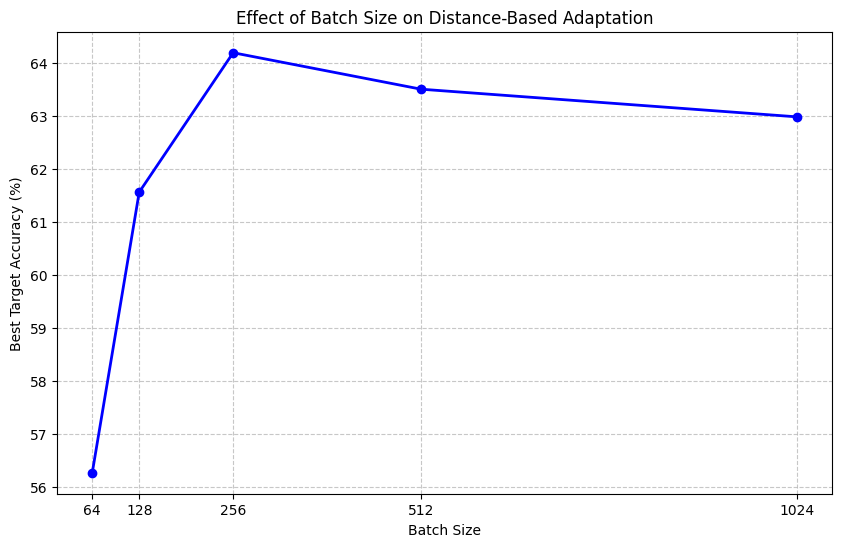

In [ ]:
# Target location of our saved model
models_path = "/content/drive/MyDrive/DA_Project/models/"
best_model_file_path = os.path.join(models_path, f"best_cnn_mnist_{BATCH_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}.pth")

BATCH_SIZES_TO_TEST = [64, 128, 256, 512, 1024]
NUM_EPOCHS = 20
LEARNING_RATE_RED = 1e-4
lambda_mmd = 1.0

experiment_results = {}

print(f" Starting Batch Size Experiment: {BATCH_SIZES_TO_TEST}")

# Experiment loop
for batch_size in BATCH_SIZES_TO_TEST:
    print(f"\n" + "="*60)
    print(f"  Running Experiment with BATCH_SIZE: {batch_size}")
    print("="*60)

    # Memory cleanup
    if 'DA_model' in locals(): del DA_model
    if 'optimizer' in locals(): del optimizer
    if 'source_train_loader' in locals(): del source_train_loader
    if 'target_train_loader' in locals(): del target_train_loader
    torch.cuda.empty_cache()
    gc.collect()

    # We already loaded 'mnist_train' and 'mnistm_train'
    source_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    target_train_loader = DataLoader(mnistm_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    # Loaders for Eval
    source_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    target_test_loader = DataLoader(mnistm_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    # Initialize Model & Load pre-trained weights from task 1
    DA_model = CNN().to(device)
    if os.path.exists(best_model_file_path):
      DA_model.load_state_dict(torch.load(best_model_file_path, map_location=device))
      print("Loaded pre-trained source weights.\n")
    else:
      print("Pre-trained weights not found. Starting from scratch.\n")

    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(DA_model.parameters(), lr=LEARNING_RATE_RED)
    geomloss_fn = SamplesLoss("energy", p=2)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(DA_model.state_dict())

    # Training loop
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        avg_ce, avg_mmd = train_epoch(
            DA_model, source_train_loader, target_train_loader,
            optimizer, criterion, geomloss_fn, lambda_mmd, device,
            epoch, NUM_EPOCHS
        )

        # Evaluation
        acc_source = evaluate_accuracy(DA_model, source_test_loader, device)
        acc_target = evaluate_accuracy(DA_model, target_test_loader, device)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] stats:")
        print(f"   Avg CE Loss:  {avg_ce:.4f}")
        print(f"   Avg MMD Loss: {avg_mmd:.4f}")
        print(f"   Source Acc:   {acc_source:.2f}% ")
        print(f"   Target Acc:   {acc_target:.2f}% \n")

        # Save best for the current batch_size
        if acc_target > best_val_acc:
            best_val_acc = acc_target
            best_model_wts = copy.deepcopy(DA_model.state_dict())

    total_time = time.time() - start_time
    experiment_results[batch_size] = best_val_acc

    print(f"\nFinished BATCH_SIZE {batch_size}. Best Target Acc: {best_val_acc:.2f}% (Time: {total_time:.1f}s)")

    # Save the best model for this batch size
    target_file_path_best = os.path.join(models_path, f"best_distance_based_DA_{batch_size}_{NUM_EPOCHS}_{LEARNING_RATE_RED}_{lambda_mmd}.pth")
    torch.save(best_model_wts, target_file_path_best)
    print(f"Saved model to {target_file_path_best}")

# Visualization
print("\nFinal Experiment Results:", experiment_results)

lists = sorted(experiment_results.items())
x, y = zip(*lists)

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', linewidth=2)
plt.title('Effect of Batch Size on Distance-Based Adaptation')
plt.xlabel('Batch Size')
plt.ylabel('Best Target Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(BATCH_SIZES_TO_TEST, labels=BATCH_SIZES_TO_TEST)
plt.show()

Here are the experiment results with accuracy reported for each batch size
- 64: 56.26%
- 128: 61.56%,
- 256: 64.2%
- 512: 63.51%,
- 1024: 62.98%

Our experiments reveal a distinct performance peak at a batch size of 256 (Accuracy: 64.2%). Crucially, this matches the batch size used for the source model pre-training. Diverging from this value—either smaller (64) or larger (1024)—resulted in performance degradation.

### 2.4.1b Batch_size tuning with different initial pretraining

To put this correlation to test, let us run the same experiment but this time with source model pretrained using 1024 as the batch size. This correlation suggests that maintaining consistency in the optimization dynamics (batch size) between pre-training and adaptation may be critical for preserving the model's learned features during fine-tuning.

 Starting Batch Size Experiment: [64, 128, 256, 512, 1024]

  Running Experiment with BATCH_SIZE: 64
Loaded pre-trained source weights.



Ep 1 | CE: 0.049 | MMD: 0.331: 100%|██████████| 922/922 [00:13<00:00, 66.12it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0647
   Avg MMD Loss: 0.6015
   Source Acc:   99.20% 
   Target Acc:   65.27% 



Ep 2 | CE: 0.014 | MMD: 0.228: 100%|██████████| 922/922 [00:14<00:00, 65.17it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0506
   Avg MMD Loss: 0.2884
   Source Acc:   99.13% 
   Target Acc:   63.89% 



Ep 3 | CE: 0.132 | MMD: 0.212: 100%|██████████| 922/922 [00:14<00:00, 64.82it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0416
   Avg MMD Loss: 0.2157
   Source Acc:   99.20% 
   Target Acc:   65.61% 



Ep 4 | CE: 0.016 | MMD: 0.153: 100%|██████████| 922/922 [00:14<00:00, 65.58it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0374
   Avg MMD Loss: 0.1760
   Source Acc:   99.16% 
   Target Acc:   65.61% 



Ep 5 | CE: 0.034 | MMD: 0.170: 100%|██████████| 922/922 [00:14<00:00, 65.84it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0321
   Avg MMD Loss: 0.1503
   Source Acc:   99.13% 
   Target Acc:   65.79% 



Ep 6 | CE: 0.113 | MMD: 0.120: 100%|██████████| 922/922 [00:14<00:00, 64.65it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0289
   Avg MMD Loss: 0.1313
   Source Acc:   99.28% 
   Target Acc:   64.67% 



Ep 7 | CE: 0.016 | MMD: 0.122: 100%|██████████| 922/922 [00:14<00:00, 65.65it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0260
   Avg MMD Loss: 0.1148
   Source Acc:   99.31% 
   Target Acc:   62.14% 



Ep 8 | CE: 0.137 | MMD: 0.101: 100%|██████████| 922/922 [00:14<00:00, 65.74it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0243
   Avg MMD Loss: 0.1039
   Source Acc:   99.27% 
   Target Acc:   63.07% 



Ep 9 | CE: 0.009 | MMD: 0.071: 100%|██████████| 922/922 [00:14<00:00, 64.81it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0212
   Avg MMD Loss: 0.0958
   Source Acc:   99.20% 
   Target Acc:   62.36% 



Ep 10 | CE: 0.046 | MMD: 0.089: 100%|██████████| 922/922 [00:14<00:00, 65.10it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0203
   Avg MMD Loss: 0.0876
   Source Acc:   99.06% 
   Target Acc:   61.76% 



Ep 11 | CE: 0.006 | MMD: 0.082: 100%|██████████| 922/922 [00:14<00:00, 64.63it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0191
   Avg MMD Loss: 0.0805
   Source Acc:   99.37% 
   Target Acc:   60.80% 



Ep 12 | CE: 0.002 | MMD: 0.059: 100%|██████████| 922/922 [00:14<00:00, 65.15it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0162
   Avg MMD Loss: 0.0756
   Source Acc:   99.29% 
   Target Acc:   62.02% 



Ep 13 | CE: 0.001 | MMD: 0.093: 100%|██████████| 922/922 [00:14<00:00, 65.12it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0154
   Avg MMD Loss: 0.0709
   Source Acc:   99.41% 
   Target Acc:   61.91% 



Ep 14 | CE: 0.002 | MMD: 0.055: 100%|██████████| 922/922 [00:14<00:00, 65.33it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0147
   Avg MMD Loss: 0.0683
   Source Acc:   99.46% 
   Target Acc:   60.74% 



Ep 15 | CE: 0.002 | MMD: 0.126: 100%|██████████| 922/922 [00:14<00:00, 65.64it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0137
   Avg MMD Loss: 0.0635
   Source Acc:   99.51% 
   Target Acc:   62.48% 



Ep 16 | CE: 0.003 | MMD: 0.056: 100%|██████████| 922/922 [00:14<00:00, 64.68it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0123
   Avg MMD Loss: 0.0577
   Source Acc:   99.34% 
   Target Acc:   63.50% 



Ep 17 | CE: 0.002 | MMD: 0.048: 100%|██████████| 922/922 [00:14<00:00, 65.20it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0109
   Avg MMD Loss: 0.0551
   Source Acc:   99.44% 
   Target Acc:   62.40% 



Ep 18 | CE: 0.023 | MMD: 0.046: 100%|██████████| 922/922 [00:14<00:00, 64.76it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0111
   Avg MMD Loss: 0.0515
   Source Acc:   99.22% 
   Target Acc:   63.66% 



Ep 19 | CE: 0.040 | MMD: 0.055: 100%|██████████| 922/922 [00:13<00:00, 66.29it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0095
   Avg MMD Loss: 0.0493
   Source Acc:   99.38% 
   Target Acc:   65.93% 



Ep 20 | CE: 0.017 | MMD: 0.096: 100%|██████████| 922/922 [00:13<00:00, 66.27it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0088
   Avg MMD Loss: 0.0456
   Source Acc:   99.46% 
   Target Acc:   63.39% 


Finished BATCH_SIZE 64. Best Target Acc: 65.93% (Time: 333.4s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_64_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 128
Loaded pre-trained source weights.



Ep 1 | CE: 0.035 | MMD: 0.262: 100%|██████████| 461/461 [00:09<00:00, 48.55it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0482
   Avg MMD Loss: 0.5494
   Source Acc:   99.22% 
   Target Acc:   62.89% 



Ep 2 | CE: 0.018 | MMD: 0.226: 100%|██████████| 461/461 [00:09<00:00, 48.59it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0417
   Avg MMD Loss: 0.2333
   Source Acc:   99.24% 
   Target Acc:   66.10% 



Ep 3 | CE: 0.077 | MMD: 0.160: 100%|██████████| 461/461 [00:09<00:00, 48.68it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0356
   Avg MMD Loss: 0.1884
   Source Acc:   99.22% 
   Target Acc:   67.39% 



Ep 4 | CE: 0.048 | MMD: 0.174: 100%|██████████| 461/461 [00:09<00:00, 48.81it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0306
   Avg MMD Loss: 0.1624
   Source Acc:   99.37% 
   Target Acc:   67.10% 



Ep 5 | CE: 0.030 | MMD: 0.127: 100%|██████████| 461/461 [00:09<00:00, 48.77it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0282
   Avg MMD Loss: 0.1387
   Source Acc:   99.32% 
   Target Acc:   68.52% 



Ep 6 | CE: 0.008 | MMD: 0.116: 100%|██████████| 461/461 [00:09<00:00, 48.36it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0268
   Avg MMD Loss: 0.1273
   Source Acc:   99.31% 
   Target Acc:   69.00% 



Ep 7 | CE: 0.015 | MMD: 0.118: 100%|██████████| 461/461 [00:09<00:00, 48.91it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0231
   Avg MMD Loss: 0.1153
   Source Acc:   99.39% 
   Target Acc:   68.92% 



Ep 8 | CE: 0.016 | MMD: 0.098: 100%|██████████| 461/461 [00:09<00:00, 48.36it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0219
   Avg MMD Loss: 0.1034
   Source Acc:   99.36% 
   Target Acc:   69.63% 



Ep 9 | CE: 0.012 | MMD: 0.087: 100%|██████████| 461/461 [00:09<00:00, 47.97it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0195
   Avg MMD Loss: 0.0962
   Source Acc:   99.42% 
   Target Acc:   70.61% 



Ep 10 | CE: 0.004 | MMD: 0.095: 100%|██████████| 461/461 [00:09<00:00, 47.94it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0184
   Avg MMD Loss: 0.0889
   Source Acc:   99.27% 
   Target Acc:   69.49% 



Ep 11 | CE: 0.012 | MMD: 0.063: 100%|██████████| 461/461 [00:09<00:00, 48.03it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0172
   Avg MMD Loss: 0.0827
   Source Acc:   99.43% 
   Target Acc:   68.86% 



Ep 12 | CE: 0.030 | MMD: 0.063: 100%|██████████| 461/461 [00:09<00:00, 47.52it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0152
   Avg MMD Loss: 0.0788
   Source Acc:   99.33% 
   Target Acc:   68.04% 



Ep 13 | CE: 0.019 | MMD: 0.070: 100%|██████████| 461/461 [00:09<00:00, 47.67it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0142
   Avg MMD Loss: 0.0730
   Source Acc:   99.44% 
   Target Acc:   70.22% 



Ep 14 | CE: 0.008 | MMD: 0.057: 100%|██████████| 461/461 [00:09<00:00, 49.65it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0135
   Avg MMD Loss: 0.0683
   Source Acc:   99.17% 
   Target Acc:   68.07% 



Ep 15 | CE: 0.003 | MMD: 0.064: 100%|██████████| 461/461 [00:09<00:00, 47.57it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0125
   Avg MMD Loss: 0.0653
   Source Acc:   99.41% 
   Target Acc:   69.74% 



Ep 16 | CE: 0.004 | MMD: 0.055: 100%|██████████| 461/461 [00:09<00:00, 48.44it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0115
   Avg MMD Loss: 0.0633
   Source Acc:   99.30% 
   Target Acc:   69.82% 



Ep 17 | CE: 0.004 | MMD: 0.049: 100%|██████████| 461/461 [00:09<00:00, 48.46it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0112
   Avg MMD Loss: 0.0616
   Source Acc:   99.42% 
   Target Acc:   68.02% 



Ep 18 | CE: 0.007 | MMD: 0.072: 100%|██████████| 461/461 [00:09<00:00, 49.34it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0103
   Avg MMD Loss: 0.0579
   Source Acc:   99.44% 
   Target Acc:   68.41% 



Ep 19 | CE: 0.009 | MMD: 0.043: 100%|██████████| 461/461 [00:09<00:00, 48.55it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0097
   Avg MMD Loss: 0.0554
   Source Acc:   99.37% 
   Target Acc:   64.66% 



Ep 20 | CE: 0.009 | MMD: 0.044: 100%|██████████| 461/461 [00:09<00:00, 47.89it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0080
   Avg MMD Loss: 0.0531
   Source Acc:   99.42% 
   Target Acc:   69.60% 


Finished BATCH_SIZE 128. Best Target Acc: 70.61% (Time: 240.7s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_128_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 256
Loaded pre-trained source weights.



Ep 1 | CE: 0.045 | MMD: 0.324: 100%|██████████| 231/231 [00:08<00:00, 26.15it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0344
   Avg MMD Loss: 0.5869
   Source Acc:   99.28% 
   Target Acc:   65.50% 



Ep 2 | CE: 0.034 | MMD: 0.214: 100%|██████████| 231/231 [00:08<00:00, 25.69it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0354
   Avg MMD Loss: 0.1968
   Source Acc:   99.33% 
   Target Acc:   67.52% 



Ep 3 | CE: 0.013 | MMD: 0.221: 100%|██████████| 231/231 [00:08<00:00, 25.80it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0302
   Avg MMD Loss: 0.1592
   Source Acc:   99.32% 
   Target Acc:   67.78% 



Ep 4 | CE: 0.019 | MMD: 0.175: 100%|██████████| 231/231 [00:09<00:00, 25.35it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0278
   Avg MMD Loss: 0.1345
   Source Acc:   99.34% 
   Target Acc:   69.52% 



Ep 5 | CE: 0.020 | MMD: 0.155: 100%|██████████| 231/231 [00:09<00:00, 25.57it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0249
   Avg MMD Loss: 0.1234
   Source Acc:   99.28% 
   Target Acc:   67.97% 



Ep 6 | CE: 0.011 | MMD: 0.147: 100%|██████████| 231/231 [00:09<00:00, 25.19it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0234
   Avg MMD Loss: 0.1116
   Source Acc:   99.37% 
   Target Acc:   69.13% 



Ep 7 | CE: 0.027 | MMD: 0.159: 100%|██████████| 231/231 [00:09<00:00, 25.60it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0220
   Avg MMD Loss: 0.1002
   Source Acc:   99.35% 
   Target Acc:   70.04% 



Ep 8 | CE: 0.014 | MMD: 0.152: 100%|██████████| 231/231 [00:09<00:00, 24.97it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0199
   Avg MMD Loss: 0.0963
   Source Acc:   99.31% 
   Target Acc:   70.70% 



Ep 9 | CE: 0.013 | MMD: 0.139: 100%|██████████| 231/231 [00:09<00:00, 25.48it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0187
   Avg MMD Loss: 0.0888
   Source Acc:   99.35% 
   Target Acc:   71.02% 



Ep 10 | CE: 0.025 | MMD: 0.145: 100%|██████████| 231/231 [00:09<00:00, 25.32it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0170
   Avg MMD Loss: 0.0848
   Source Acc:   99.30% 
   Target Acc:   71.40% 



Ep 11 | CE: 0.015 | MMD: 0.116: 100%|██████████| 231/231 [00:09<00:00, 25.47it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0158
   Avg MMD Loss: 0.0803
   Source Acc:   99.33% 
   Target Acc:   71.16% 



Ep 12 | CE: 0.011 | MMD: 0.101: 100%|██████████| 231/231 [00:09<00:00, 25.46it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0145
   Avg MMD Loss: 0.0766
   Source Acc:   99.36% 
   Target Acc:   71.78% 



Ep 13 | CE: 0.009 | MMD: 0.149: 100%|██████████| 231/231 [00:08<00:00, 26.34it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0134
   Avg MMD Loss: 0.0721
   Source Acc:   99.35% 
   Target Acc:   71.07% 



Ep 14 | CE: 0.011 | MMD: 0.197: 100%|██████████| 231/231 [00:08<00:00, 26.15it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0135
   Avg MMD Loss: 0.0693
   Source Acc:   99.43% 
   Target Acc:   72.26% 



Ep 15 | CE: 0.011 | MMD: 0.087: 100%|██████████| 231/231 [00:08<00:00, 25.96it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0119
   Avg MMD Loss: 0.0668
   Source Acc:   99.45% 
   Target Acc:   70.38% 



Ep 16 | CE: 0.016 | MMD: 0.092: 100%|██████████| 231/231 [00:09<00:00, 25.58it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0104
   Avg MMD Loss: 0.0644
   Source Acc:   99.44% 
   Target Acc:   71.88% 



Ep 17 | CE: 0.015 | MMD: 0.099: 100%|██████████| 231/231 [00:09<00:00, 25.51it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0603
   Source Acc:   99.40% 
   Target Acc:   69.70% 



Ep 18 | CE: 0.005 | MMD: 0.087: 100%|██████████| 231/231 [00:09<00:00, 25.27it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0576
   Source Acc:   99.41% 
   Target Acc:   72.29% 



Ep 19 | CE: 0.008 | MMD: 0.118: 100%|██████████| 231/231 [00:08<00:00, 25.76it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0092
   Avg MMD Loss: 0.0559
   Source Acc:   99.40% 
   Target Acc:   73.18% 



Ep 20 | CE: 0.003 | MMD: 0.134: 100%|██████████| 231/231 [00:08<00:00, 25.80it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0083
   Avg MMD Loss: 0.0543
   Source Acc:   99.39% 
   Target Acc:   71.17% 


Finished BATCH_SIZE 256. Best Target Acc: 73.18% (Time: 229.9s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_256_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 512
Loaded pre-trained source weights.



Ep 1 | CE: 0.019 | MMD: 0.420: 100%|██████████| 116/116 [00:09<00:00, 12.88it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0248
   Avg MMD Loss: 0.7631
   Source Acc:   99.41% 
   Target Acc:   63.84% 



Ep 2 | CE: 0.008 | MMD: 0.344: 100%|██████████| 116/116 [00:08<00:00, 13.37it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0305
   Avg MMD Loss: 0.1937
   Source Acc:   99.28% 
   Target Acc:   66.39% 



Ep 3 | CE: 0.019 | MMD: 0.242: 100%|██████████| 116/116 [00:08<00:00, 13.35it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0283
   Avg MMD Loss: 0.1441
   Source Acc:   99.37% 
   Target Acc:   67.37% 



Ep 4 | CE: 0.026 | MMD: 0.223: 100%|██████████| 116/116 [00:08<00:00, 13.26it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0258
   Avg MMD Loss: 0.1242
   Source Acc:   99.34% 
   Target Acc:   67.26% 



Ep 5 | CE: 0.018 | MMD: 0.254: 100%|██████████| 116/116 [00:08<00:00, 13.22it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0237
   Avg MMD Loss: 0.1095
   Source Acc:   99.35% 
   Target Acc:   67.92% 



Ep 6 | CE: 0.024 | MMD: 0.336: 100%|██████████| 116/116 [00:08<00:00, 13.46it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0215
   Avg MMD Loss: 0.0991
   Source Acc:   99.42% 
   Target Acc:   68.72% 



Ep 7 | CE: 0.020 | MMD: 0.216: 100%|██████████| 116/116 [00:08<00:00, 13.28it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0211
   Avg MMD Loss: 0.0919
   Source Acc:   99.47% 
   Target Acc:   68.79% 



Ep 8 | CE: 0.018 | MMD: 0.187: 100%|██████████| 116/116 [00:08<00:00, 13.22it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0182
   Avg MMD Loss: 0.0857
   Source Acc:   99.37% 
   Target Acc:   69.82% 



Ep 9 | CE: 0.016 | MMD: 0.168: 100%|██████████| 116/116 [00:08<00:00, 13.45it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0178
   Avg MMD Loss: 0.0802
   Source Acc:   99.40% 
   Target Acc:   70.29% 



Ep 10 | CE: 0.024 | MMD: 0.152: 100%|██████████| 116/116 [00:09<00:00, 12.80it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0159
   Avg MMD Loss: 0.0753
   Source Acc:   99.43% 
   Target Acc:   70.04% 



Ep 11 | CE: 0.009 | MMD: 0.290: 100%|██████████| 116/116 [00:08<00:00, 13.05it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0159
   Avg MMD Loss: 0.0733
   Source Acc:   99.43% 
   Target Acc:   70.66% 



Ep 12 | CE: 0.015 | MMD: 0.189: 100%|██████████| 116/116 [00:08<00:00, 13.08it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0144
   Avg MMD Loss: 0.0689
   Source Acc:   99.42% 
   Target Acc:   70.24% 



Ep 13 | CE: 0.009 | MMD: 0.207: 100%|██████████| 116/116 [00:08<00:00, 13.34it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0139
   Avg MMD Loss: 0.0658
   Source Acc:   99.32% 
   Target Acc:   69.99% 



Ep 14 | CE: 0.018 | MMD: 0.142: 100%|██████████| 116/116 [00:08<00:00, 13.21it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0131
   Avg MMD Loss: 0.0645
   Source Acc:   99.41% 
   Target Acc:   71.44% 



Ep 15 | CE: 0.016 | MMD: 0.155: 100%|██████████| 116/116 [00:08<00:00, 13.24it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0119
   Avg MMD Loss: 0.0605
   Source Acc:   99.46% 
   Target Acc:   71.93% 



Ep 16 | CE: 0.007 | MMD: 0.138: 100%|██████████| 116/116 [00:08<00:00, 13.12it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0112
   Avg MMD Loss: 0.0596
   Source Acc:   99.42% 
   Target Acc:   71.92% 



Ep 17 | CE: 0.006 | MMD: 0.124: 100%|██████████| 116/116 [00:08<00:00, 13.45it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0112
   Avg MMD Loss: 0.0570
   Source Acc:   99.39% 
   Target Acc:   71.12% 



Ep 18 | CE: 0.021 | MMD: 0.121: 100%|██████████| 116/116 [00:08<00:00, 13.22it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0105
   Avg MMD Loss: 0.0564
   Source Acc:   99.43% 
   Target Acc:   71.98% 



Ep 19 | CE: 0.005 | MMD: 0.130: 100%|██████████| 116/116 [00:08<00:00, 13.63it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0097
   Avg MMD Loss: 0.0548
   Source Acc:   99.43% 
   Target Acc:   72.60% 



Ep 20 | CE: 0.006 | MMD: 0.108: 100%|██████████| 116/116 [00:08<00:00, 13.26it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0088
   Avg MMD Loss: 0.0525
   Source Acc:   99.39% 
   Target Acc:   71.31% 


Finished BATCH_SIZE 512. Best Target Acc: 72.60% (Time: 227.4s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_512_20_0.0001_1.0.pth

  Running Experiment with BATCH_SIZE: 1024
Loaded pre-trained source weights.



Ep 1 | CE: 0.022 | MMD: 0.396: 100%|██████████| 58/58 [00:08<00:00,  6.72it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0200
   Avg MMD Loss: 1.1302
   Source Acc:   99.34% 
   Target Acc:   62.70% 



Ep 2 | CE: 0.026 | MMD: 0.212: 100%|██████████| 58/58 [00:08<00:00,  6.47it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0255
   Avg MMD Loss: 0.2530
   Source Acc:   99.33% 
   Target Acc:   63.80% 



Ep 3 | CE: 0.032 | MMD: 0.156: 100%|██████████| 58/58 [00:08<00:00,  6.63it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0251
   Avg MMD Loss: 0.1659
   Source Acc:   99.37% 
   Target Acc:   65.86% 



Ep 4 | CE: 0.027 | MMD: 0.131: 100%|██████████| 58/58 [00:08<00:00,  6.58it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0242
   Avg MMD Loss: 0.1315
   Source Acc:   99.34% 
   Target Acc:   66.86% 



Ep 5 | CE: 0.021 | MMD: 0.125: 100%|██████████| 58/58 [00:09<00:00,  6.42it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0229
   Avg MMD Loss: 0.1117
   Source Acc:   99.40% 
   Target Acc:   67.03% 



Ep 6 | CE: 0.017 | MMD: 0.101: 100%|██████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0217
   Avg MMD Loss: 0.0995
   Source Acc:   99.40% 
   Target Acc:   67.86% 



Ep 7 | CE: 0.017 | MMD: 0.096: 100%|██████████| 58/58 [00:08<00:00,  6.50it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0203
   Avg MMD Loss: 0.0896
   Source Acc:   99.39% 
   Target Acc:   68.00% 



Ep 8 | CE: 0.011 | MMD: 0.090: 100%|██████████| 58/58 [00:08<00:00,  6.68it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0193
   Avg MMD Loss: 0.0832
   Source Acc:   99.37% 
   Target Acc:   68.27% 



Ep 9 | CE: 0.018 | MMD: 0.082: 100%|██████████| 58/58 [00:08<00:00,  6.88it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0191
   Avg MMD Loss: 0.0767
   Source Acc:   99.37% 
   Target Acc:   68.76% 



Ep 10 | CE: 0.020 | MMD: 0.076: 100%|██████████| 58/58 [00:08<00:00,  6.98it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0174
   Avg MMD Loss: 0.0717
   Source Acc:   99.26% 
   Target Acc:   69.21% 



Ep 11 | CE: 0.021 | MMD: 0.086: 100%|██████████| 58/58 [00:08<00:00,  6.82it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0162
   Avg MMD Loss: 0.0691
   Source Acc:   99.38% 
   Target Acc:   69.49% 



Ep 12 | CE: 0.018 | MMD: 0.069: 100%|██████████| 58/58 [00:08<00:00,  6.55it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0157
   Avg MMD Loss: 0.0654
   Source Acc:   99.42% 
   Target Acc:   69.53% 



Ep 13 | CE: 0.012 | MMD: 0.081: 100%|██████████| 58/58 [00:08<00:00,  6.80it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0142
   Avg MMD Loss: 0.0620
   Source Acc:   99.34% 
   Target Acc:   70.46% 



Ep 14 | CE: 0.009 | MMD: 0.069: 100%|██████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0144
   Avg MMD Loss: 0.0593
   Source Acc:   99.44% 
   Target Acc:   69.36% 



Ep 15 | CE: 0.010 | MMD: 0.069: 100%|██████████| 58/58 [00:09<00:00,  6.31it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0138
   Avg MMD Loss: 0.0580
   Source Acc:   99.42% 
   Target Acc:   70.03% 



Ep 16 | CE: 0.009 | MMD: 0.070: 100%|██████████| 58/58 [00:08<00:00,  6.49it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0124
   Avg MMD Loss: 0.0561
   Source Acc:   99.40% 
   Target Acc:   69.79% 



Ep 17 | CE: 0.020 | MMD: 0.057: 100%|██████████| 58/58 [00:09<00:00,  6.30it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0121
   Avg MMD Loss: 0.0533
   Source Acc:   99.34% 
   Target Acc:   70.34% 



Ep 18 | CE: 0.006 | MMD: 0.057: 100%|██████████| 58/58 [00:09<00:00,  6.41it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0121
   Avg MMD Loss: 0.0512
   Source Acc:   99.45% 
   Target Acc:   70.68% 



Ep 19 | CE: 0.018 | MMD: 0.061: 100%|██████████| 58/58 [00:08<00:00,  6.64it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0115
   Avg MMD Loss: 0.0493
   Source Acc:   99.40% 
   Target Acc:   70.78% 



Ep 20 | CE: 0.009 | MMD: 0.057: 100%|██████████| 58/58 [00:08<00:00,  6.67it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0105
   Avg MMD Loss: 0.0482
   Source Acc:   99.40% 
   Target Acc:   70.32% 


Finished BATCH_SIZE 1024. Best Target Acc: 70.78% (Time: 233.8s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_1024_20_0.0001_1.0.pth

Final Experiment Results: {64: 65.93333333333334, 128: 70.61111111111111, 256: 73.17777777777778, 512: 72.6, 1024: 70.77777777777777}


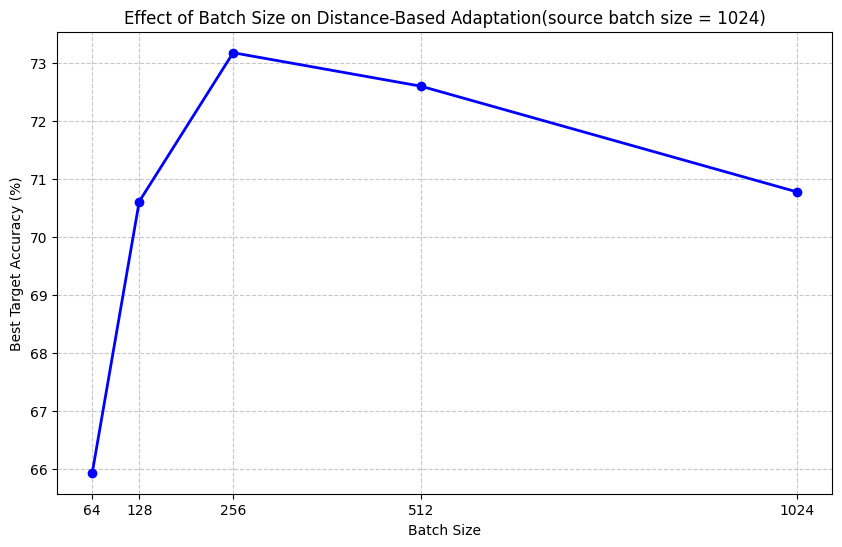

In [ ]:
# Target location of our saved model
models_path = "/content/drive/MyDrive/DA_Project/models/"
best_model_file_path = os.path.join(models_path, f"best_cnn_mnist_{1024}_{NUM_EPOCHS}_{LEARNING_RATE}.pth")

BATCH_SIZES_TO_TEST = [64, 128, 256, 512, 1024]
NUM_EPOCHS = 20
LEARNING_RATE_RED = 1e-4
lambda_mmd = 1.0

experiment_results = {}

print(f" Starting Batch Size Experiment: {BATCH_SIZES_TO_TEST}")

# Experiment loop
for batch_size in BATCH_SIZES_TO_TEST:
    print(f"\n" + "="*60)
    print(f"  Running Experiment with BATCH_SIZE: {batch_size}")
    print("="*60)

    # Memory cleanup
    if 'DA_model' in locals(): del DA_model
    if 'optimizer' in locals(): del optimizer
    if 'source_train_loader' in locals(): del source_train_loader
    if 'target_train_loader' in locals(): del target_train_loader
    torch.cuda.empty_cache()
    gc.collect()

    # We already loaded 'mnist_train' and 'mnistm_train'
    source_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    target_train_loader = DataLoader(mnistm_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    # Loaders for Eval
    source_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    target_test_loader = DataLoader(mnistm_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    # Initialize Model & Load pre-trained weights from task 1
    DA_model = CNN().to(device)
    if os.path.exists(best_model_file_path):
      DA_model.load_state_dict(torch.load(best_model_file_path, map_location=device))
      print("Loaded pre-trained source weights.\n")
    else:
      print("Pre-trained weights not found. Starting from scratch.\n")

    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(DA_model.parameters(), lr=LEARNING_RATE_RED)
    geomloss_fn = SamplesLoss("energy", p=2)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(DA_model.state_dict())

    # Training loop
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        avg_ce, avg_mmd = train_epoch(
            DA_model, source_train_loader, target_train_loader,
            optimizer, criterion, geomloss_fn, lambda_mmd, device,
            epoch, NUM_EPOCHS
        )

        # Evaluation
        acc_source = evaluate_accuracy(DA_model, source_test_loader, device)
        acc_target = evaluate_accuracy(DA_model, target_test_loader, device)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] stats:")
        print(f"   Avg CE Loss:  {avg_ce:.4f}")
        print(f"   Avg MMD Loss: {avg_mmd:.4f}")
        print(f"   Source Acc:   {acc_source:.2f}% ")
        print(f"   Target Acc:   {acc_target:.2f}% \n")

        # Save best for the current batch_size
        if acc_target > best_val_acc:
            best_val_acc = acc_target
            best_model_wts = copy.deepcopy(DA_model.state_dict())

    total_time = time.time() - start_time
    experiment_results[batch_size] = best_val_acc

    print(f"\nFinished BATCH_SIZE {batch_size}. Best Target Acc: {best_val_acc:.2f}% (Time: {total_time:.1f}s)")

    # Save the best model for this batch size
    target_file_path_best = os.path.join(models_path, f"best_distance_based_DA_{batch_size}_{NUM_EPOCHS}_{LEARNING_RATE_RED}_{lambda_mmd}.pth")
    torch.save(best_model_wts, target_file_path_best)
    print(f"Saved model to {target_file_path_best}")

# Visualization
print("\nFinal Experiment Results:", experiment_results)

lists = sorted(experiment_results.items())
x, y = zip(*lists)

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', linewidth=2)
plt.title('Effect of Batch Size on Distance-Based Adaptation(source batch size = 1024)')
plt.xlabel('Batch Size')
plt.ylabel('Best Target Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(BATCH_SIZES_TO_TEST, labels=BATCH_SIZES_TO_TEST)
plt.show()

Final Experiment Results:
- 64: 65.93%
- 128: 70.61%
- 256: 73.17%
- 512: 72.6%
- 1024: 70.77%

Contrary to our hypothesis, initializing with a Batch-1024 model did not shift the optimal adaptation batch size to 1024. The performance still peaked at Batch 256 (73.18%), with a slight degradation at 1024 (70.78%).

This behavior is likely attributable to the fixed learning rate (1e-4
 ) used across all experiments. According to the Linear Scaling Rule, larger batch sizes require proportionally larger learning rates to maintain convergence speed (since they perform fewer updates per epoch). By keeping the learning rate constant, the larger batch models (512, 1024) likely suffered from an effectively reduced training capacity, preventing them from fully exploiting the superior statistical alignment of the larger batches. Batch 256 represents the sweet spot where the learning rate was optimal for the number of gradient updates.

 ### 2.4.1c Batch_size tuning with different initial pretraining and scaled learning rate

 Let us perform one final experiment to see if scaling the learning rate will lead to increased performance.

 Starting Batch Size Experiment: [64, 128, 256, 512, 1024]

  Running Experiment with BATCH_SIZE: 64
Loaded pre-trained source weights.



Ep 1 | CE: 0.045 | MMD: 0.396: 100%|██████████| 922/922 [00:14<00:00, 63.68it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0616
   Avg MMD Loss: 0.7361
   Source Acc:   99.11% 
   Target Acc:   62.14% 



Ep 2 | CE: 0.017 | MMD: 0.322: 100%|██████████| 922/922 [00:14<00:00, 64.23it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0533
   Avg MMD Loss: 0.3419
   Source Acc:   99.24% 
   Target Acc:   62.72% 



Ep 3 | CE: 0.087 | MMD: 0.236: 100%|██████████| 922/922 [00:14<00:00, 63.98it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0438
   Avg MMD Loss: 0.2591
   Source Acc:   99.19% 
   Target Acc:   66.60% 



Ep 4 | CE: 0.030 | MMD: 0.260: 100%|██████████| 922/922 [00:14<00:00, 64.58it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0381
   Avg MMD Loss: 0.2121
   Source Acc:   99.22% 
   Target Acc:   65.72% 



Ep 5 | CE: 0.078 | MMD: 0.182: 100%|██████████| 922/922 [00:14<00:00, 64.55it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0359
   Avg MMD Loss: 0.1822
   Source Acc:   99.28% 
   Target Acc:   65.12% 



Ep 6 | CE: 0.023 | MMD: 0.131: 100%|██████████| 922/922 [00:14<00:00, 65.08it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0323
   Avg MMD Loss: 0.1570
   Source Acc:   99.26% 
   Target Acc:   63.26% 



Ep 7 | CE: 0.030 | MMD: 0.141: 100%|██████████| 922/922 [00:14<00:00, 64.76it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0295
   Avg MMD Loss: 0.1390
   Source Acc:   99.10% 
   Target Acc:   63.73% 



Ep 8 | CE: 0.023 | MMD: 0.295: 100%|██████████| 922/922 [00:14<00:00, 65.59it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0269
   Avg MMD Loss: 0.1276
   Source Acc:   99.14% 
   Target Acc:   63.09% 



Ep 9 | CE: 0.004 | MMD: 0.100: 100%|██████████| 922/922 [00:14<00:00, 65.17it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0252
   Avg MMD Loss: 0.1160
   Source Acc:   99.38% 
   Target Acc:   63.44% 



Ep 10 | CE: 0.015 | MMD: 0.106: 100%|██████████| 922/922 [00:14<00:00, 64.75it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0219
   Avg MMD Loss: 0.1067
   Source Acc:   99.14% 
   Target Acc:   62.28% 



Ep 11 | CE: 0.008 | MMD: 0.079: 100%|██████████| 922/922 [00:14<00:00, 64.96it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0209
   Avg MMD Loss: 0.0983
   Source Acc:   99.09% 
   Target Acc:   61.32% 



Ep 12 | CE: 0.061 | MMD: 0.120: 100%|██████████| 922/922 [00:14<00:00, 64.90it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0185
   Avg MMD Loss: 0.0937
   Source Acc:   99.33% 
   Target Acc:   58.77% 



Ep 13 | CE: 0.014 | MMD: 0.109: 100%|██████████| 922/922 [00:14<00:00, 64.53it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0181
   Avg MMD Loss: 0.0883
   Source Acc:   99.32% 
   Target Acc:   59.28% 



Ep 14 | CE: 0.004 | MMD: 0.114: 100%|██████████| 922/922 [00:14<00:00, 64.54it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0166
   Avg MMD Loss: 0.0828
   Source Acc:   99.26% 
   Target Acc:   58.50% 



Ep 15 | CE: 0.077 | MMD: 0.062: 100%|██████████| 922/922 [00:14<00:00, 65.00it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0158
   Avg MMD Loss: 0.0787
   Source Acc:   99.09% 
   Target Acc:   59.29% 



Ep 16 | CE: 0.010 | MMD: 0.057: 100%|██████████| 922/922 [00:14<00:00, 64.58it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0139
   Avg MMD Loss: 0.0747
   Source Acc:   99.14% 
   Target Acc:   60.29% 



Ep 17 | CE: 0.004 | MMD: 0.063: 100%|██████████| 922/922 [00:14<00:00, 63.75it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0132
   Avg MMD Loss: 0.0718
   Source Acc:   99.26% 
   Target Acc:   56.90% 



Ep 18 | CE: 0.008 | MMD: 0.061: 100%|██████████| 922/922 [00:14<00:00, 64.92it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0133
   Avg MMD Loss: 0.0688
   Source Acc:   99.22% 
   Target Acc:   56.57% 



Ep 19 | CE: 0.016 | MMD: 0.059: 100%|██████████| 922/922 [00:14<00:00, 65.46it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0123
   Avg MMD Loss: 0.0648
   Source Acc:   99.01% 
   Target Acc:   58.59% 



Ep 20 | CE: 0.011 | MMD: 0.051: 100%|██████████| 922/922 [00:14<00:00, 64.80it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0105
   Avg MMD Loss: 0.0616
   Source Acc:   99.31% 
   Target Acc:   59.57% 


Finished BATCH_SIZE 64. Best Target Acc: 66.60% (Time: 337.5s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_64_20_6.25e-05_1.0.pth

  Running Experiment with BATCH_SIZE: 128
Loaded pre-trained source weights.



Ep 1 | CE: 0.036 | MMD: 0.234: 100%|██████████| 461/461 [00:09<00:00, 48.53it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0479
   Avg MMD Loss: 0.4937
   Source Acc:   99.20% 
   Target Acc:   67.50% 



Ep 2 | CE: 0.083 | MMD: 0.179: 100%|██████████| 461/461 [00:09<00:00, 48.26it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0419
   Avg MMD Loss: 0.2172
   Source Acc:   99.26% 
   Target Acc:   66.42% 



Ep 3 | CE: 0.015 | MMD: 0.166: 100%|██████████| 461/461 [00:09<00:00, 47.92it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0343
   Avg MMD Loss: 0.1733
   Source Acc:   99.24% 
   Target Acc:   68.28% 



Ep 4 | CE: 0.010 | MMD: 0.167: 100%|██████████| 461/461 [00:09<00:00, 48.67it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0302
   Avg MMD Loss: 0.1451
   Source Acc:   99.10% 
   Target Acc:   70.41% 



Ep 5 | CE: 0.065 | MMD: 0.103: 100%|██████████| 461/461 [00:09<00:00, 48.49it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0264
   Avg MMD Loss: 0.1275
   Source Acc:   99.34% 
   Target Acc:   71.03% 



Ep 6 | CE: 0.008 | MMD: 0.098: 100%|██████████| 461/461 [00:09<00:00, 48.92it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0248
   Avg MMD Loss: 0.1161
   Source Acc:   99.45% 
   Target Acc:   71.88% 



Ep 7 | CE: 0.022 | MMD: 0.086: 100%|██████████| 461/461 [00:09<00:00, 47.50it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0228
   Avg MMD Loss: 0.1014
   Source Acc:   99.21% 
   Target Acc:   70.81% 



Ep 8 | CE: 0.030 | MMD: 0.076: 100%|██████████| 461/461 [00:09<00:00, 47.57it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0202
   Avg MMD Loss: 0.0934
   Source Acc:   99.22% 
   Target Acc:   72.32% 



Ep 9 | CE: 0.021 | MMD: 0.077: 100%|██████████| 461/461 [00:09<00:00, 47.58it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0196
   Avg MMD Loss: 0.0863
   Source Acc:   99.43% 
   Target Acc:   71.70% 



Ep 10 | CE: 0.009 | MMD: 0.074: 100%|██████████| 461/461 [00:09<00:00, 48.32it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0179
   Avg MMD Loss: 0.0790
   Source Acc:   99.32% 
   Target Acc:   70.49% 



Ep 11 | CE: 0.062 | MMD: 0.072: 100%|██████████| 461/461 [00:09<00:00, 48.26it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0156
   Avg MMD Loss: 0.0740
   Source Acc:   99.46% 
   Target Acc:   69.63% 



Ep 12 | CE: 0.020 | MMD: 0.061: 100%|██████████| 461/461 [00:09<00:00, 47.98it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0148
   Avg MMD Loss: 0.0719
   Source Acc:   99.31% 
   Target Acc:   67.30% 



Ep 13 | CE: 0.022 | MMD: 0.053: 100%|██████████| 461/461 [00:09<00:00, 48.99it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0136
   Avg MMD Loss: 0.0655
   Source Acc:   99.28% 
   Target Acc:   70.08% 



Ep 14 | CE: 0.037 | MMD: 0.052: 100%|██████████| 461/461 [00:09<00:00, 47.87it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0131
   Avg MMD Loss: 0.0639
   Source Acc:   99.41% 
   Target Acc:   70.90% 



Ep 15 | CE: 0.019 | MMD: 0.049: 100%|██████████| 461/461 [00:09<00:00, 47.96it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0116
   Avg MMD Loss: 0.0584
   Source Acc:   99.36% 
   Target Acc:   71.19% 



Ep 16 | CE: 0.022 | MMD: 0.052: 100%|██████████| 461/461 [00:09<00:00, 47.99it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0096
   Avg MMD Loss: 0.0552
   Source Acc:   99.18% 
   Target Acc:   69.94% 



Ep 17 | CE: 0.004 | MMD: 0.042: 100%|██████████| 461/461 [00:09<00:00, 47.01it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0099
   Avg MMD Loss: 0.0531
   Source Acc:   99.37% 
   Target Acc:   71.13% 



Ep 18 | CE: 0.004 | MMD: 0.046: 100%|██████████| 461/461 [00:09<00:00, 48.35it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0091
   Avg MMD Loss: 0.0516
   Source Acc:   99.23% 
   Target Acc:   69.81% 



Ep 19 | CE: 0.003 | MMD: 0.094: 100%|██████████| 461/461 [00:09<00:00, 47.90it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0098
   Avg MMD Loss: 0.0504
   Source Acc:   99.40% 
   Target Acc:   70.61% 



Ep 20 | CE: 0.006 | MMD: 0.055: 100%|██████████| 461/461 [00:09<00:00, 48.60it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0080
   Avg MMD Loss: 0.0457
   Source Acc:   99.38% 
   Target Acc:   71.06% 


Finished BATCH_SIZE 128. Best Target Acc: 72.32% (Time: 243.4s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_128_20_0.000125_1.0.pth

  Running Experiment with BATCH_SIZE: 256
Loaded pre-trained source weights.



Ep 1 | CE: 0.033 | MMD: 0.233: 100%|██████████| 231/231 [00:08<00:00, 25.94it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0432
   Avg MMD Loss: 0.3604
   Source Acc:   99.16% 
   Target Acc:   68.28% 



Ep 2 | CE: 0.034 | MMD: 0.167: 100%|██████████| 231/231 [00:09<00:00, 25.39it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0351
   Avg MMD Loss: 0.1467
   Source Acc:   99.21% 
   Target Acc:   67.64% 



Ep 3 | CE: 0.027 | MMD: 0.144: 100%|██████████| 231/231 [00:09<00:00, 25.26it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0306
   Avg MMD Loss: 0.1174
   Source Acc:   99.24% 
   Target Acc:   72.73% 



Ep 4 | CE: 0.025 | MMD: 0.116: 100%|██████████| 231/231 [00:09<00:00, 25.22it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0251
   Avg MMD Loss: 0.1036
   Source Acc:   99.35% 
   Target Acc:   74.39% 



Ep 5 | CE: 0.016 | MMD: 0.148: 100%|██████████| 231/231 [00:09<00:00, 25.34it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0238
   Avg MMD Loss: 0.0902
   Source Acc:   99.34% 
   Target Acc:   72.78% 



Ep 6 | CE: 0.019 | MMD: 0.098: 100%|██████████| 231/231 [00:09<00:00, 25.22it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0207
   Avg MMD Loss: 0.0827
   Source Acc:   99.37% 
   Target Acc:   73.36% 



Ep 7 | CE: 0.013 | MMD: 0.092: 100%|██████████| 231/231 [00:09<00:00, 24.50it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0192
   Avg MMD Loss: 0.0736
   Source Acc:   99.36% 
   Target Acc:   74.26% 



Ep 8 | CE: 0.030 | MMD: 0.129: 100%|██████████| 231/231 [00:09<00:00, 24.91it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0171
   Avg MMD Loss: 0.0685
   Source Acc:   99.41% 
   Target Acc:   76.69% 



Ep 9 | CE: 0.038 | MMD: 0.083: 100%|██████████| 231/231 [00:08<00:00, 25.87it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0155
   Avg MMD Loss: 0.0648
   Source Acc:   99.31% 
   Target Acc:   72.29% 



Ep 10 | CE: 0.019 | MMD: 0.069: 100%|██████████| 231/231 [00:08<00:00, 25.92it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0156
   Avg MMD Loss: 0.0563
   Source Acc:   99.48% 
   Target Acc:   74.51% 



Ep 11 | CE: 0.011 | MMD: 0.077: 100%|██████████| 231/231 [00:08<00:00, 25.93it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0131
   Avg MMD Loss: 0.0555
   Source Acc:   99.38% 
   Target Acc:   75.00% 



Ep 12 | CE: 0.007 | MMD: 0.053: 100%|██████████| 231/231 [00:08<00:00, 25.91it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0121
   Avg MMD Loss: 0.0500
   Source Acc:   99.44% 
   Target Acc:   73.89% 



Ep 13 | CE: 0.009 | MMD: 0.135: 100%|██████████| 231/231 [00:08<00:00, 26.10it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0475
   Source Acc:   98.97% 
   Target Acc:   73.53% 



Ep 14 | CE: 0.011 | MMD: 0.051: 100%|██████████| 231/231 [00:08<00:00, 25.85it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0108
   Avg MMD Loss: 0.0454
   Source Acc:   99.26% 
   Target Acc:   74.10% 



Ep 15 | CE: 0.009 | MMD: 0.050: 100%|██████████| 231/231 [00:09<00:00, 25.66it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0099
   Avg MMD Loss: 0.0423
   Source Acc:   99.35% 
   Target Acc:   73.90% 



Ep 16 | CE: 0.006 | MMD: 0.044: 100%|██████████| 231/231 [00:09<00:00, 25.57it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0080
   Avg MMD Loss: 0.0408
   Source Acc:   99.44% 
   Target Acc:   73.79% 



Ep 17 | CE: 0.005 | MMD: 0.088: 100%|██████████| 231/231 [00:09<00:00, 25.59it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0088
   Avg MMD Loss: 0.0386
   Source Acc:   99.33% 
   Target Acc:   74.97% 



Ep 18 | CE: 0.007 | MMD: 0.037: 100%|██████████| 231/231 [00:09<00:00, 24.98it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0067
   Avg MMD Loss: 0.0362
   Source Acc:   99.46% 
   Target Acc:   74.32% 



Ep 19 | CE: 0.013 | MMD: 0.044: 100%|██████████| 231/231 [00:09<00:00, 25.07it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0060
   Avg MMD Loss: 0.0338
   Source Acc:   99.43% 
   Target Acc:   75.81% 



Ep 20 | CE: 0.003 | MMD: 0.046: 100%|██████████| 231/231 [00:09<00:00, 25.52it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0062
   Avg MMD Loss: 0.0332
   Source Acc:   99.44% 
   Target Acc:   75.50% 


Finished BATCH_SIZE 256. Best Target Acc: 76.69% (Time: 231.8s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_256_20_0.00025_1.0.pth

  Running Experiment with BATCH_SIZE: 512
Loaded pre-trained source weights.



Ep 1 | CE: 0.021 | MMD: 0.258: 100%|██████████| 116/116 [00:08<00:00, 13.32it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0460
   Avg MMD Loss: 0.3000
   Source Acc:   99.39% 
   Target Acc:   70.84% 



Ep 2 | CE: 0.030 | MMD: 0.194: 100%|██████████| 116/116 [00:08<00:00, 13.09it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0345
   Avg MMD Loss: 0.1061
   Source Acc:   99.19% 
   Target Acc:   69.82% 



Ep 3 | CE: 0.022 | MMD: 0.159: 100%|██████████| 116/116 [00:08<00:00, 13.55it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0286
   Avg MMD Loss: 0.0854
   Source Acc:   99.31% 
   Target Acc:   72.49% 



Ep 4 | CE: 0.032 | MMD: 0.124: 100%|██████████| 116/116 [00:08<00:00, 12.97it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0254
   Avg MMD Loss: 0.0709
   Source Acc:   99.45% 
   Target Acc:   72.16% 



Ep 5 | CE: 0.015 | MMD: 0.129: 100%|██████████| 116/116 [00:08<00:00, 13.41it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0213
   Avg MMD Loss: 0.0656
   Source Acc:   99.48% 
   Target Acc:   70.88% 



Ep 6 | CE: 0.014 | MMD: 0.139: 100%|██████████| 116/116 [00:09<00:00, 12.78it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0197
   Avg MMD Loss: 0.0599
   Source Acc:   99.47% 
   Target Acc:   75.72% 



Ep 7 | CE: 0.044 | MMD: 0.112: 100%|██████████| 116/116 [00:08<00:00, 13.14it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0196
   Avg MMD Loss: 0.0571
   Source Acc:   99.40% 
   Target Acc:   74.88% 



Ep 8 | CE: 0.008 | MMD: 0.106: 100%|██████████| 116/116 [00:08<00:00, 12.97it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0173
   Avg MMD Loss: 0.0521
   Source Acc:   99.41% 
   Target Acc:   76.10% 



Ep 9 | CE: 0.010 | MMD: 0.099: 100%|██████████| 116/116 [00:09<00:00, 12.78it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0168
   Avg MMD Loss: 0.0482
   Source Acc:   99.32% 
   Target Acc:   74.77% 



Ep 10 | CE: 0.017 | MMD: 0.096: 100%|██████████| 116/116 [00:08<00:00, 13.14it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0139
   Avg MMD Loss: 0.0427
   Source Acc:   99.36% 
   Target Acc:   77.53% 



Ep 11 | CE: 0.005 | MMD: 0.073: 100%|██████████| 116/116 [00:08<00:00, 13.07it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0116
   Avg MMD Loss: 0.0398
   Source Acc:   99.15% 
   Target Acc:   75.21% 



Ep 12 | CE: 0.007 | MMD: 0.101: 100%|██████████| 116/116 [00:08<00:00, 13.12it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0106
   Avg MMD Loss: 0.0363
   Source Acc:   99.53% 
   Target Acc:   75.84% 



Ep 13 | CE: 0.011 | MMD: 0.072: 100%|██████████| 116/116 [00:08<00:00, 12.99it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0098
   Avg MMD Loss: 0.0377
   Source Acc:   99.51% 
   Target Acc:   75.89% 



Ep 14 | CE: 0.003 | MMD: 0.068: 100%|██████████| 116/116 [00:08<00:00, 13.31it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0092
   Avg MMD Loss: 0.0353
   Source Acc:   99.46% 
   Target Acc:   78.09% 



Ep 15 | CE: 0.001 | MMD: 0.065: 100%|██████████| 116/116 [00:08<00:00, 13.33it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0077
   Avg MMD Loss: 0.0318
   Source Acc:   99.53% 
   Target Acc:   77.40% 



Ep 16 | CE: 0.005 | MMD: 0.097: 100%|██████████| 116/116 [00:08<00:00, 13.33it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0076
   Avg MMD Loss: 0.0313
   Source Acc:   99.50% 
   Target Acc:   76.28% 



Ep 17 | CE: 0.004 | MMD: 0.109: 100%|██████████| 116/116 [00:08<00:00, 13.23it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0058
   Avg MMD Loss: 0.0288
   Source Acc:   99.49% 
   Target Acc:   76.97% 



Ep 18 | CE: 0.006 | MMD: 0.051: 100%|██████████| 116/116 [00:08<00:00, 13.17it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0062
   Avg MMD Loss: 0.0282
   Source Acc:   99.34% 
   Target Acc:   77.53% 



Ep 19 | CE: 0.003 | MMD: 0.058: 100%|██████████| 116/116 [00:08<00:00, 12.95it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0056
   Avg MMD Loss: 0.0261
   Source Acc:   99.46% 
   Target Acc:   75.87% 



Ep 20 | CE: 0.006 | MMD: 0.046: 100%|██████████| 116/116 [00:08<00:00, 13.00it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0050
   Avg MMD Loss: 0.0262
   Source Acc:   99.45% 
   Target Acc:   77.96% 


Finished BATCH_SIZE 512. Best Target Acc: 78.09% (Time: 228.7s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_512_20_0.0005_1.0.pth

  Running Experiment with BATCH_SIZE: 1024
Loaded pre-trained source weights.



Ep 1 | CE: 0.031 | MMD: 0.110: 100%|██████████| 58/58 [00:08<00:00,  6.57it/s]


Epoch [1/20] stats:
   Avg CE Loss:  0.0549
   Avg MMD Loss: 0.2955
   Source Acc:   99.24% 
   Target Acc:   70.13% 



Ep 2 | CE: 0.034 | MMD: 0.078: 100%|██████████| 58/58 [00:08<00:00,  6.62it/s]


Epoch [2/20] stats:
   Avg CE Loss:  0.0379
   Avg MMD Loss: 0.0805
   Source Acc:   99.34% 
   Target Acc:   72.49% 



Ep 3 | CE: 0.019 | MMD: 0.066: 100%|██████████| 58/58 [00:08<00:00,  6.60it/s]


Epoch [3/20] stats:
   Avg CE Loss:  0.0332
   Avg MMD Loss: 0.0647
   Source Acc:   99.45% 
   Target Acc:   74.21% 



Ep 4 | CE: 0.052 | MMD: 0.060: 100%|██████████| 58/58 [00:08<00:00,  6.72it/s]


Epoch [4/20] stats:
   Avg CE Loss:  0.0277
   Avg MMD Loss: 0.0558
   Source Acc:   99.39% 
   Target Acc:   76.53% 



Ep 5 | CE: 0.018 | MMD: 0.058: 100%|██████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch [5/20] stats:
   Avg CE Loss:  0.0251
   Avg MMD Loss: 0.0504
   Source Acc:   99.49% 
   Target Acc:   75.22% 



Ep 6 | CE: 0.017 | MMD: 0.060: 100%|██████████| 58/58 [00:08<00:00,  6.78it/s]


Epoch [6/20] stats:
   Avg CE Loss:  0.0202
   Avg MMD Loss: 0.0452
   Source Acc:   99.55% 
   Target Acc:   76.28% 



Ep 7 | CE: 0.029 | MMD: 0.048: 100%|██████████| 58/58 [00:08<00:00,  6.75it/s]


Epoch [7/20] stats:
   Avg CE Loss:  0.0190
   Avg MMD Loss: 0.0413
   Source Acc:   99.49% 
   Target Acc:   75.49% 



Ep 8 | CE: 0.021 | MMD: 0.045: 100%|██████████| 58/58 [00:08<00:00,  6.79it/s]


Epoch [8/20] stats:
   Avg CE Loss:  0.0170
   Avg MMD Loss: 0.0387
   Source Acc:   99.48% 
   Target Acc:   77.31% 



Ep 9 | CE: 0.013 | MMD: 0.039: 100%|██████████| 58/58 [00:08<00:00,  6.76it/s]


Epoch [9/20] stats:
   Avg CE Loss:  0.0148
   Avg MMD Loss: 0.0376
   Source Acc:   99.43% 
   Target Acc:   76.46% 



Ep 10 | CE: 0.018 | MMD: 0.054: 100%|██████████| 58/58 [00:08<00:00,  6.51it/s]


Epoch [10/20] stats:
   Avg CE Loss:  0.0144
   Avg MMD Loss: 0.0346
   Source Acc:   99.48% 
   Target Acc:   77.86% 



Ep 11 | CE: 0.013 | MMD: 0.040: 100%|██████████| 58/58 [00:08<00:00,  6.67it/s]


Epoch [11/20] stats:
   Avg CE Loss:  0.0136
   Avg MMD Loss: 0.0319
   Source Acc:   99.42% 
   Target Acc:   77.93% 



Ep 12 | CE: 0.009 | MMD: 0.043: 100%|██████████| 58/58 [00:08<00:00,  6.59it/s]


Epoch [12/20] stats:
   Avg CE Loss:  0.0130
   Avg MMD Loss: 0.0300
   Source Acc:   99.51% 
   Target Acc:   77.71% 



Ep 13 | CE: 0.011 | MMD: 0.031: 100%|██████████| 58/58 [00:09<00:00,  6.38it/s]


Epoch [13/20] stats:
   Avg CE Loss:  0.0116
   Avg MMD Loss: 0.0290
   Source Acc:   99.41% 
   Target Acc:   77.92% 



Ep 14 | CE: 0.008 | MMD: 0.033: 100%|██████████| 58/58 [00:08<00:00,  6.46it/s]


Epoch [14/20] stats:
   Avg CE Loss:  0.0101
   Avg MMD Loss: 0.0263
   Source Acc:   99.35% 
   Target Acc:   79.09% 



Ep 15 | CE: 0.014 | MMD: 0.024: 100%|██████████| 58/58 [00:09<00:00,  6.44it/s]


Epoch [15/20] stats:
   Avg CE Loss:  0.0087
   Avg MMD Loss: 0.0268
   Source Acc:   99.42% 
   Target Acc:   78.40% 



Ep 16 | CE: 0.004 | MMD: 0.025: 100%|██████████| 58/58 [00:08<00:00,  6.74it/s]


Epoch [16/20] stats:
   Avg CE Loss:  0.0078
   Avg MMD Loss: 0.0272
   Source Acc:   99.31% 
   Target Acc:   78.41% 



Ep 17 | CE: 0.011 | MMD: 0.023: 100%|██████████| 58/58 [00:09<00:00,  6.44it/s]


Epoch [17/20] stats:
   Avg CE Loss:  0.0082
   Avg MMD Loss: 0.0222
   Source Acc:   99.56% 
   Target Acc:   79.36% 



Ep 18 | CE: 0.003 | MMD: 0.029: 100%|██████████| 58/58 [00:08<00:00,  6.54it/s]


Epoch [18/20] stats:
   Avg CE Loss:  0.0056
   Avg MMD Loss: 0.0205
   Source Acc:   99.44% 
   Target Acc:   77.92% 



Ep 19 | CE: 0.007 | MMD: 0.024: 100%|██████████| 58/58 [00:09<00:00,  6.39it/s]


Epoch [19/20] stats:
   Avg CE Loss:  0.0057
   Avg MMD Loss: 0.0215
   Source Acc:   99.38% 
   Target Acc:   78.69% 



Ep 20 | CE: 0.003 | MMD: 0.018: 100%|██████████| 58/58 [00:08<00:00,  6.59it/s]


Epoch [20/20] stats:
   Avg CE Loss:  0.0056
   Avg MMD Loss: 0.0200
   Source Acc:   99.44% 
   Target Acc:   79.28% 


Finished BATCH_SIZE 1024. Best Target Acc: 79.36% (Time: 234.8s)
Saved model to /content/drive/MyDrive/DA_Project/models/best_distance_based_DA_1024_20_0.001_1.0.pth

Final Experiment Results: {64: 66.6, 128: 72.32222222222222, 256: 76.68888888888888, 512: 78.08888888888889, 1024: 79.35555555555555}


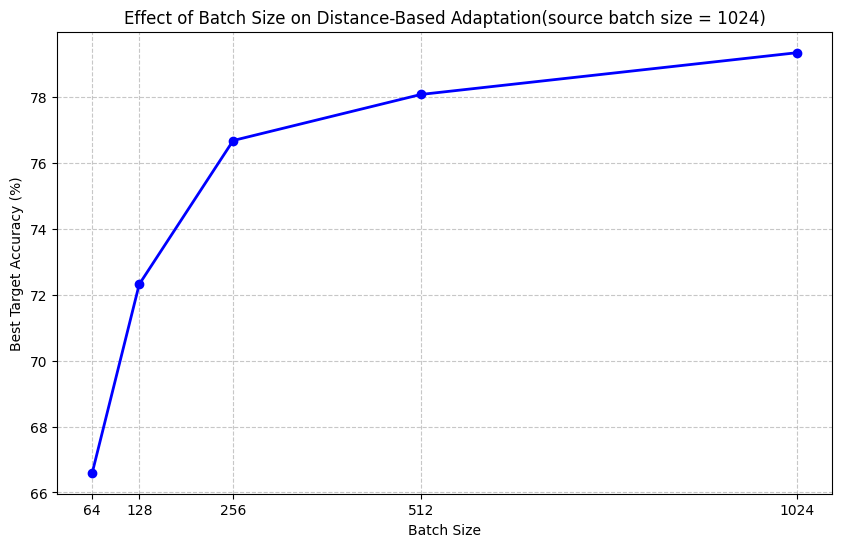

In [ ]:
# Target location of our saved model

SOURCE_BATCH_SIZE = 1024
SOURCE_LR = 1e-3
models_path = "/content/drive/MyDrive/DA_Project/models/"
best_model_file_path = os.path.join(models_path, f"best_cnn_mnist_{SOURCE_BATCH_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}.pth")

BATCH_SIZES_TO_TEST = [64, 128, 256, 512, 1024]
NUM_EPOCHS = 20
lambda_mmd = 1.0

experiment_results = {}

print(f" Starting Batch Size Experiment: {BATCH_SIZES_TO_TEST}")

# Experiment loop
for batch_size in BATCH_SIZES_TO_TEST:
    print(f"\n" + "="*60)
    print(f"  Running Experiment with BATCH_SIZE: {batch_size}")
    print("="*60)

    # Scaling learning rate
    LEARNING_RATE_RED = SOURCE_LR * batch_size / SOURCE_BATCH_SIZE

    # Memory cleanup
    if 'DA_model' in locals(): del DA_model
    if 'optimizer' in locals(): del optimizer
    if 'source_train_loader' in locals(): del source_train_loader
    if 'target_train_loader' in locals(): del target_train_loader
    torch.cuda.empty_cache()
    gc.collect()

    # We already loaded 'mnist_train' and 'mnistm_train'
    source_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    target_train_loader = DataLoader(mnistm_train, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

    # Loaders for Eval
    source_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    target_test_loader = DataLoader(mnistm_test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    # Initialize Model & Load pre-trained weights from task 1
    DA_model = CNN().to(device)
    if os.path.exists(best_model_file_path):
      DA_model.load_state_dict(torch.load(best_model_file_path, map_location=device))
      print("Loaded pre-trained source weights.\n")
    else:
      print("Pre-trained weights not found. Starting from scratch.\n")

    # Setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(DA_model.parameters(), lr=LEARNING_RATE_RED)
    geomloss_fn = SamplesLoss("energy", p=2)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(DA_model.state_dict())

    # Training loop
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        avg_ce, avg_mmd = train_epoch(
            DA_model, source_train_loader, target_train_loader,
            optimizer, criterion, geomloss_fn, lambda_mmd, device,
            epoch, NUM_EPOCHS
        )

        # Evaluation
        acc_source = evaluate_accuracy(DA_model, source_test_loader, device)
        acc_target = evaluate_accuracy(DA_model, target_test_loader, device)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] stats:")
        print(f"   Avg CE Loss:  {avg_ce:.4f}")
        print(f"   Avg MMD Loss: {avg_mmd:.4f}")
        print(f"   Source Acc:   {acc_source:.2f}% ")
        print(f"   Target Acc:   {acc_target:.2f}% \n")

        # Save best for the current batch_size
        if acc_target > best_val_acc:
            best_val_acc = acc_target
            best_model_wts = copy.deepcopy(DA_model.state_dict())

    total_time = time.time() - start_time
    experiment_results[batch_size] = best_val_acc

    print(f"\nFinished BATCH_SIZE {batch_size}. Best Target Acc: {best_val_acc:.2f}% (Time: {total_time:.1f}s)")

    # Save the best model for this batch size
    target_file_path_best = os.path.join(models_path, f"best_distance_based_DA_{batch_size}_{NUM_EPOCHS}_{LEARNING_RATE_RED}_{lambda_mmd}.pth")
    torch.save(best_model_wts, target_file_path_best)
    print(f"Saved model to {target_file_path_best}")

# Visualization
print("\nFinal Experiment Results:", experiment_results)

lists = sorted(experiment_results.items())
x, y = zip(*lists)

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', linewidth=2)
plt.title('Effect of Batch Size on Distance-Based Adaptation(source batch size = 1024)')
plt.xlabel('Batch Size')
plt.ylabel('Best Target Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(BATCH_SIZES_TO_TEST, labels=BATCH_SIZES_TO_TEST)
plt.show()

By applying the Linear Scaling Rule (scaling the learning rate proportionally with batch size), we successfully mitigated the optimization difficulties observed in the fixed-LR experiments. The results show a clear monotonic improvement in adaptation performance as batch size increases, peaking at 79.36% with Batch 1024.

This confirms that distance-based alignment benefits significantly from larger batch sizes (due to more accurate distribution estimates), provided the optimization hyperparameters are adjusted to maintain training dynamics.